# Topic Modeling with Gensim

based on https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

__Goal__: extract good quality topics that are clear, segregated and meaningful

In [3]:
from datetime import datetime, timezone
import json
import logging
import os
import re
import time

import numpy as np
import pandas as pd
import pickle

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LdaMulticore, Phrases, TfidfModel
from gensim.models.phrases import Phraser
from gensim.models.wrappers import ldamallet

# nltk
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

# Enbale logging for gensim
logging.basicConfig(format='%(asctime)s: %(levelname)s : %(message)s', level=logging.ERROR)

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
HOME = os.environ['HOME']
KEYS = f'{HOME}/config/db.json'
ENV = 'dev'
NOW = datetime.now(timezone.utc)
TODAY = NOW.date()

DATA_DIR = '../data'
MODEL_DIR = '../model'
SQL_DIR = '../sql'
OUT_DIR = '../output'

DEV = False

In [5]:
if DEV:
    RUN_DATE = '2021-02-24'
else:
    RUN_DATE = str(TODAY)
RUN_DATE

'2021-03-15'

#### Load data

In [6]:
# clean comments
data = pd.read_csv(f'{DATA_DIR}/clean_data_{RUN_DATE}.csv')

In [7]:
data

,comment,title,subreddit,score
0,company original instance container docker swa...,building jenkins pipeline,devops,2
1,analogy breaks actively maintained jenkins hor...,building jenkins pipeline,devops,2
2,solutions architecture customer engineering pe...,industries life devops,devops,3
3,moved jenkins helm jenkins operator working au...,building jenkins pipeline,devops,1
4,unsure open moving based profit hospital perso...,industries life devops,devops,3
...,...,...,...,...
417949,discount gpu performance 1080p video monitors ...,staff desktop computers,sysadmin,1
417950,numbers based tpu review fairly cpu load heavy,rocket lake microcode offers performance gains...,hardware,1
417951,browser extension compromise security variable...,thoughts password managers,sysadmin,0
417952,male representation industry worked talented f...,leaning networking journey life,networking,1


In [97]:
uniqe_titles = data.title.unique()
print(data.title.unique())

['building jenkins pipeline' 'industries life devops' 'experience relic'
 ... 'successfull reflection attack authentication'
 'software examples configure powerful permission surveillance'
 'learning path deep fake machine learning apps reface wombo ai deep nostalgia']


In [98]:
data['comment_len'] = data.comment.apply(len)

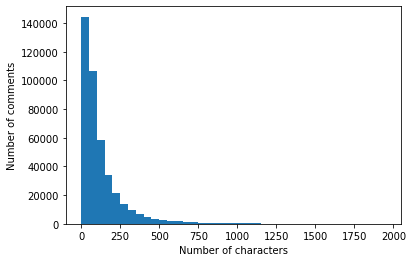

In [99]:
plt.hist(data.comment_len.values, bins = range(0, 2000, 50))
plt.xlabel('Number of characters')
plt.ylabel('Number of comments')
plt.show()

## Preprocess comments

- Tokenize comments
- Remove stopwords
- Make bigram/trigram
- Lemmatize the tokens (words in comments)
- Compute a TF-IDF vector representation of the tokens

### Tokenization


Tokenization is the process of breaking complex data (like paragraphs) into simple units called __tokens__

In [100]:
def tokenize(doc):
    for sentence in doc:
        yield(simple_preprocess(str(sentence), deacc=True)) # deacc=True removes punctuations

In [101]:
data.head()

,comment,title,subreddit,score,comment_len
0,company original instance container docker swa...,building jenkins pipeline,devops,2,1551
1,analogy breaks actively maintained jenkins hor...,building jenkins pipeline,devops,2,132
2,solutions architecture customer engineering pe...,industries life devops,devops,3,210
3,moved jenkins helm jenkins operator working au...,building jenkins pipeline,devops,1,142
4,unsure open moving based profit hospital perso...,industries life devops,devops,3,210


### Remove stopwords

In [102]:
stop_words = stopwords.words('english')
stop_words.extend(['feel', 'aint', 'wtf', 'hell', 'kid', 'heh', 'ha', 'youtu', 
                   'hmm', 'не', 'kinda', 'fine', 'nah', 'nope', 'huh', 'die',
                   'joke', 'yup', 'great', 'fun', 'issue', 'stuff', 'point', 
                   'feel', 'crap', 'fucking', 'fuck', 'dude', 'damn', 'suck',
                   'lmao', 'stupid', 'haha', 'lol', 'nice', 'yeah', 'cool',  
                   'didnt', 'youll', 'youv', 'big', 'yep', 'bot', 'yikes',
                   'ya', 'tho', 'jesus', 'totally', 'chill', 'god', 'amazing',
                   'nep', 'remindme', 'holy', 'as', 'wanna', 'ftw', 'enjoy',
                   'gotta', 'crazy', 'die', 'small', 'hey', 'ban', 'bro',
                   'guess', 'kid', 'bad', 'long', 'interesting', 'man',
                   'wrong', 'kid', 'easy', 'difficult', 'upvote', 'like',
                   'funny', 'friend', 'literally', 'hate', 'free', 'sucks',
                   'dont', 'ill', 'https', 'laugh', 'ass', 'omg'])

In [103]:
len(stop_words)

268

In [104]:
def remove_stopwords(doc):
    return doc.apply(
        lambda sent: [word for word in sent if word not in stop_words])

### Create Bigram & Trigram models

- Bigram are 2 words frequently occuring together in a document
- Trigram are 3 words frequently occuring together in a document

In [105]:
# # Build bigram model
# def build_bigram_mod(doc):
#     bigram_text = Phrases(doc, min_count=1, threshold=100) # higher threshold fewer phrases.
#     # Faster way to get a sentence clubbed as a trigram/bigram
#     return Phraser(bigram_text)

In [106]:
# def make_bigrams(doc):
#     bigram_text = Phrases(doc, min_count=1, threshold=10) # higher threshold fewer phrases.
#     # Faster way to get a sentence clubbed as a trigram/bigram
#     mod = Phraser(bigram_text)
#     return [mod[sent] for sent in doc]

In [107]:
# def make_trigrams(doc):
#     bigram_text = Phrases(doc, min_count=1, threshold=10) # higher threshold fewer phrases.
#     # Faster way to get a sentence clubbed as a trigram/bigram
#     mod = Phraser(bigram_text)
#     return [mod[sent] for sent in doc]

### Stemming
- Stemming is a normalization technique where list of tokenized words are converted into shorter root words called stems (note: stems are not always the root word)
- Drop last letter or prefix or suffix - may not produce meaningful words
- Stemming may reduce the accuracy of the model

In [108]:
def stemming(doc, stemmer_type):
    if stemmer_type=='port':
        stemmer = PorterStemmer()
    elif stemmer_type=='snow':
        stemmer = SnowballStemmer('english')
    stemmed_text = doc.apply(
            lambda sent: [stemmer.stem(word) for word in sent])
    return stemmed_text

### Lemmatization
- Lemmatization is the morphological analysis of the words - returning meaningful words
- Requires more disk space and processing time
- Leads to higher model accuaracy
- Root word is called __lemma__

In [109]:
lemmatizer = WordNetLemmatizer()
def lemmatization(doc):
    return doc.apply(
        lambda sent: [lemmatizer.lemmatize(word) for word in sent])

In [111]:
tokenized_comments = list(tokenize(data.comment))
data['tokenized_comment'] = tokenized_comments 
print('Tokenized:\n', data.tokenized_comment[3])

# Remove stopwords
nostops_comments = remove_stopwords(data.tokenized_comment)
print('\nWithout stopwords:\n', nostops_comments[3])
data['tokenized_comment'] = nostops_comments # replace with clean tokenized

# Form bigrams
# bigram_comments = make_bigrams(data.tokenized_comment)
bigram = Phrases(data.tokenized_comment, min_count=1, threshold=10) # higher threshold fewer places
# data['bigram'] = 
# print('bigram_comments:', bigram[3])

# trigram = Phrases(bigram[data.tokenized_comment], threshold=100) # higher threshold fewer places
# print('triram_comments:', trigram[3])

# # Port stemmer
# # port_comments = stemming(data.tokenized_comment, 'port')
# # print('\nPort stemmer:\n', port_comments[3])

# Snowball stemmer
snow_comments = stemming(data.tokenized_comment, 'snow')
print('\nSnow stemmer:\n', snow_comments[3])
data['stemmed_comment'] = snow_comments 

# Lemmatization
lemmatized_comments = lemmatization(data.tokenized_comment)
print('\nLemmatized:\n', lemmatized_comments[3])
data['lemmatized_comment'] = lemmatized_comments

Tokenized:
 ['moved', 'jenkins', 'helm', 'jenkins', 'operator', 'working', 'automated', 'jobs', 'creation', 'github', 'topics', 'wen', 'project', 'imported', 'jenkins', 'jenkinsfile', 'topic', 'repo', 'settings']

Without stopwords:
 ['moved', 'jenkins', 'helm', 'jenkins', 'operator', 'working', 'automated', 'jobs', 'creation', 'github', 'topics', 'wen', 'project', 'imported', 'jenkins', 'jenkinsfile', 'topic', 'repo', 'settings']

Snow stemmer:
 ['move', 'jenkin', 'helm', 'jenkin', 'oper', 'work', 'autom', 'job', 'creation', 'github', 'topic', 'wen', 'project', 'import', 'jenkin', 'jenkinsfil', 'topic', 'repo', 'set']

Lemmatized:
 ['moved', 'jenkins', 'helm', 'jenkins', 'operator', 'working', 'automated', 'job', 'creation', 'github', 'topic', 'wen', 'project', 'imported', 'jenkins', 'jenkinsfile', 'topic', 'repo', 'setting']


In [112]:
tokenized_titles = list(tokenize(data.title))
data['tokenized_title'] = tokenized_titles 
print('Tokenized:\n', data.tokenized_title[3])

# Remove stopwords
nostops_titles = remove_stopwords(data.tokenized_title)
print('\nWithout stopwords:\n', nostops_titles[3])
data['tokenized_title'] = nostops_titles # replace with clean tokenized

# Stemming
snow_titles = stemming(data.tokenized_title, 'snow')
print('\nSnow stemmer:\n', snow_titles[3])
data['stemmed_title'] = snow_titles

# Lemmatizing
lemmatized_titles = lemmatization(data.tokenized_title)
print('\nLemmatized:\n', lemmatized_titles[3])
data['lemmatized_title'] = lemmatized_titles

Tokenized:
 ['building', 'jenkins', 'pipeline']

Without stopwords:
 ['building', 'jenkins', 'pipeline']

Snow stemmer:
 ['build', 'jenkin', 'pipelin']

Lemmatized:
 ['building', 'jenkins', 'pipeline']


In [113]:
data.head()

,comment,title,subreddit,score,comment_len,tokenized_comment,stemmed_comment,lemmatized_comment,tokenized_title,stemmed_title,lemmatized_title
0,company original instance container docker swa...,building jenkins pipeline,devops,2,1551,"[company, original, instance, container, docke...","[compani, origin, instanc, contain, docker, sw...","[company, original, instance, container, docke...","[building, jenkins, pipeline]","[build, jenkin, pipelin]","[building, jenkins, pipeline]"
1,analogy breaks actively maintained jenkins hor...,building jenkins pipeline,devops,2,132,"[analogy, breaks, actively, maintained, jenkin...","[analog, break, activ, maintain, jenkin, horre...","[analogy, break, actively, maintained, jenkins...","[building, jenkins, pipeline]","[build, jenkin, pipelin]","[building, jenkins, pipeline]"
2,solutions architecture customer engineering pe...,industries life devops,devops,3,210,"[solutions, architecture, customer, engineerin...","[solut, architectur, custom, engin, perfect, c...","[solution, architecture, customer, engineering...","[industries, life, devops]","[industri, life, devop]","[industry, life, devops]"
3,moved jenkins helm jenkins operator working au...,building jenkins pipeline,devops,1,142,"[moved, jenkins, helm, jenkins, operator, work...","[move, jenkin, helm, jenkin, oper, work, autom...","[moved, jenkins, helm, jenkins, operator, work...","[building, jenkins, pipeline]","[build, jenkin, pipelin]","[building, jenkins, pipeline]"
4,unsure open moving based profit hospital perso...,industries life devops,devops,3,210,"[unsure, open, moving, based, profit, hospital...","[unsur, open, move, base, profit, hospit, pers...","[unsure, open, moving, based, profit, hospital...","[industries, life, devops]","[industri, life, devop]","[industry, life, devops]"


In [279]:
data[data.subreddit == 'devops'].comment[2]

'solutions architecture customer engineering perfect customer facing skills develop wider view tech landscape roles stay technical build demos pocs daily project implementation grind cloud providers hiring roles'

### Create dictionary, corpus and vectorized corpus needed for Topic modeling

In [185]:
# Create dictionary representation of the documents
dictionary_l = corpora.Dictionary(data.lemmatized_comment)
dictionary_s = corpora.Dictionary(data.stemmed_comment)

In [186]:
# Filter out words that occur in less than 20% documents, and above 50% documents
dictionary_l.filter_extremes(no_below=20, no_above=0.5)
dictionary_s.filter_extremes(no_below=20, no_above=0.5)

In [187]:
print(dictionary_l[15])
print(dictionary_s[15])

cache
code


In [188]:
# Bag of words
corpus_l = [dictionary_l.doc2bow(comment) for comment in data.lemmatized_comment]
corpus_s = [dictionary_s.doc2bow(comment) for comment in data.stemmed_comment]

In [189]:
print(corpus_l[:5])

[[(0, 8), (1, 1), (2, 2), (3, 3), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 2), (13, 3), (14, 2), (15, 1), (16, 1), (17, 2), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 8), (24, 1), (25, 1), (26, 2), (27, 2), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 4), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 6), (46, 1), (47, 1), (48, 1), (49, 2), (50, 2), (51, 1), (52, 1), (53, 1), (54, 3), (55, 1), (56, 1), (57, 1), (58, 1), (59, 2), (60, 1), (61, 2), (62, 1), (63, 1), (64, 6), (65, 1), (66, 3), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 4), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 3), (80, 2), (81, 1), (82, 2), (83, 1), (84, 2), (85, 1), (86, 1), (87, 1), (88, 1), (89, 4), (90, 3), (91, 2), (92, 3), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 2), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 2), (106, 1), (107, 1), (108, 1), (109, 5), (110, 1)

In [190]:
# Human readable form of the BoW
print([[(dictionary_l[id], freq) for id, freq in word] for word in corpus_l[:5]])

[[('access', 8), ('active', 1), ('admin', 2), ('agent', 3), ('app', 1), ('assign', 1), ('assigned', 1), ('authentication', 1), ('authorization', 2), ('automatically', 1), ('avoid', 1), ('base', 1), ('based', 2), ('build', 3), ('building', 2), ('cache', 1), ('chose', 1), ('cluster', 2), ('code', 2), ('company', 1), ('configuration', 1), ('configure', 1), ('configured', 1), ('container', 8), ('control', 1), ('correct', 1), ('create', 2), ('created', 2), ('creation', 1), ('credential', 1), ('data', 1), ('decided', 2), ('define', 1), ('dependency', 1), ('deployed', 1), ('deployment', 1), ('develop', 1), ('directory', 1), ('docker', 4), ('downside', 1), ('duplicated', 1), ('dynamic', 1), ('environment', 1), ('ephemeral', 1), ('fit', 1), ('folder', 6), ('freedom', 1), ('function', 1), ('generation', 1), ('goal', 2), ('group', 2), ('handful', 1), ('hundred', 1), ('identical', 1), ('image', 3), ('included', 1), ('includes', 1), ('initial', 1), ('installed', 1), ('instance', 2), ('issue', 1), (

- $[(0, 1)]$ above implies: word-id $0$ - occurs once in the first document (comment)

In [191]:
# Compute TF-IDF score for each word in BoW ( lemmatized corpus)
tfidf_mod_l = TfidfModel(corpus_l, normalize=True)
vectorized_corpus_l = tfidf_mod_l[corpus_l]

# Compute TF-IDF score for each word in BoW (stemmed corpus)
tfidf_mod_s = TfidfModel(corpus_s, normalize=True)
vectorized_corpus_s = tfidf_mod_s[corpus_s]

In [192]:
print(tfidf_mod_l[vectorized_corpus_l[0]])
print(tfidf_mod_s[vectorized_corpus_s[0]])

[(0, 0.17235897297849845), (1, 0.043162958313321946), (2, 0.06879325739605367), (3, 0.1643255906301306), (4, 0.028628789470039512), (5, 0.06584902778798685), (6, 0.06238338803144956), (7, 0.050236596332486914), (8, 0.18280647411972958), (9, 0.044390729897789465), (10, 0.03924470500346019), (11, 0.03826080330802083), (12, 0.043597882894606754), (13, 0.07226292735643683), (14, 0.06264758131725105), (15, 0.04493750624982096), (16, 0.0624163996742619), (17, 0.09681027411307365), (18, 0.03194731458226286), (19, 0.012491974784958684), (20, 0.03750861796008082), (21, 0.046767736669453906), (22, 0.047380341362299794), (23, 0.37129984988100634), (24, 0.027783997905576154), (25, 0.031575075923907965), (26, 0.05762132049832374), (27, 0.08165529836938504), (28, 0.06898830934965078), (29, 0.051229236769408236), (30, 0.01595794326602942), (31, 0.08720909069553999), (32, 0.05424948833852731), (33, 0.05324900991095927), (34, 0.055149877406730545), (35, 0.04279816325521208), (36, 0.049149971091144565),

### Building the topic model

In [193]:
subreddits = data.subreddit.unique()
print('no. of topics:', len(subreddits))
print(subreddits)

no. of topics: 7
['devops' 'MachineLearning' 'cybersecurity' 'networking' 'programming'
 'hardware' 'sysadmin']


In [57]:
# Set training parameters.
num_topics = 7, # no. of subreddits
chunksize = 500
passes = 10
iterations = 500
eval_every = None # None - don't evaluate model perplexity, takes too much time.
workers = 6

# alpha and eta - affect sparsity of topics - defaults to 1.0/num_topics
# chunksize - control how many documents are processed at a time in training
# update_every - determined how often the parameters should be updated
# passes - total number of training passes
# iteration - control how often a particular loop is repeated over each document 
# eval_every - evaluate no. of passes and iterations
# workers - number of workers processes to be used for parallelization. 
#         - If None all available cores (as estimated by workers=cpu_count()-1 will be used

# Note - set passes and iterations high

In [58]:
# Print the keywords in the topics
def print_topics(model):
    for topic_num, words_in_topic in model.print_topics(-1):
        print(f'Topic {topic_num+1}:  Words: {words_in_topic}')

In [59]:
def print_coherence_score(model, corpus, dictionary, texts):
    # Compute Perplexity - lemmatized
    print(f'\n- Perplexity: {model.log_perplexity(corpus):.4f}')  # a measure of how good the model is. lower the better.
    # Compute Coherence Score using lemmatized comments
    coherence = CoherenceModel(
        model=model, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
    print(f'- Coherence Score: {coherence:.4f}')

#### LDA on TF-IDF

In [60]:
# corpus - bow/tfidf dictionary of lemmatized or stemmed words

def build_lda(
    corpus, dictionary, corpus_type, num_topics, texts, chunksize=500, 
    passes=10, iterations=500, eval_every=None, workers=6):
    start = time.time()
    print(f'Building LDA model using {corpus_type} corpus...')
    mod = LdaMulticore(corpus=corpus,
                       id2word=dictionary,
                       num_topics=num_topics,
                       chunksize=chunksize,
                       passes=passes,
                       iterations=iterations,
                       workers=workers,
                       eval_every=eval_every)
    print(f' - {time.time()-start:.4f}s\n')
    print_topics(mod)
    print_coherence_score(mod, corpus, dictionary, texts)
    return mod

In [198]:
# lemmatized corpus
lda_tfidf_lemma_mod = build_lda(
    corpus=vectorized_corpus_l,
    dictionary=dictionary_l,
    corpus_type='tfidf-lemmatized',
    num_topics=7,
    texts=data.lemmatized_comment)

Building LDA model using tfidf-lemmatized corpus...
 - 462.4807s

Topic 1:  Words: 0.007*"server" + 0.007*"user" + 0.007*"window" + 0.006*"password" + 0.006*"file" + 0.004*"linux" + 0.004*"update" + 0.004*"account" + 0.004*"access" + 0.004*"email"
Topic 2:  Words: 0.008*"job" + 0.007*"company" + 0.005*"security" + 0.004*"team" + 0.004*"day" + 0.004*"experience" + 0.003*"working" + 0.003*"business" + 0.003*"money" + 0.003*"engineer"
Topic 3:  Words: 0.008*"language" + 0.008*"code" + 0.005*"data" + 0.005*"python" + 0.005*"model" + 0.004*"problem" + 0.004*"paper" + 0.004*"learning" + 0.004*"programming" + 0.004*"function"
Topic 4:  Words: 0.009*"switch" + 0.009*"network" + 0.007*"port" + 0.006*"device" + 0.006*"router" + 0.005*"firewall" + 0.005*"cisco" + 0.005*"traffic" + 0.005*"address" + 0.004*"vpn"
Topic 5:  Words: 0.010*"card" + 0.008*"price" + 0.007*"game" + 0.007*"nvidia" + 0.007*"gpu" + 0.007*"cpu" + 0.006*"intel" + 0.006*"performance" + 0.006*"amd" + 0.006*"chip"
Topic 6:  Words:

Model perplexity and topic coherence provide a measure to judge how good a given topic model is

- top 10 words in each topic along with their weights
- weights reflect how important a word is to the topic

In [199]:
pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim.prepare(lda_tfidf_lemma_mod, vectorized_corpus_l, dictionary_l)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.078530 -0.056782       1        1  20.380310
0     -0.115676  0.100252       2        1  18.542185
4      0.015495  0.021871       3        1  15.147456
2     -0.126710 -0.014248       4        1  14.925679
5     -0.033831 -0.280617       5        1  11.687272
3     -0.045846  0.215548       6        1  11.426573
6      0.385097  0.013976       7        1   7.890523, topic_info=          Term         Freq        Total Category  logprob  loglift
3682    mining  1184.000000  1184.000000  Default  30.0000  30.0000
1004      card  2043.000000  2043.000000  Default  29.0000  29.0000
902     nvidia  1283.000000  1283.000000  Default  28.0000  28.0000
1715  language  1489.000000  1489.000000  Default  27.0000  27.0000
894        gpu  1287.000000  1287.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1542       org   307.476379   816.617920   Topic7  -5.6878   1.5627
948        car   242.675018   534.278259   Topic7  -5.9245   1.7503
1906     drive   248.399109  1064.912964   Topic7  -5.9011   1.0839
1182       buy   249.021851  1432.329346   Topic7  -5.8986   0.7900
3795       sad   206.073517   304.681976   Topic7  -6.0879   2.1485

[471 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.073403   access
0         2  0.581410   access
0         3  0.023256   access
0         4  0.037792   access
0         5  0.005814   access
...     ...       ...      ...
1624      3  0.041653  youtube
1624      4  0.019438  youtube
1624      5  0.161058  youtube
1624      7  0.619239  youtube
5733      3  0.998130      zen

[1120 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 5, 3, 6, 4, 7])

In [200]:
# stemmed corpus
lda_tfidf_stem_mod = build_lda(
    corpus=vectorized_corpus_s,
    dictionary=dictionary_s,
    corpus_type='tfidf-stemmed',
    texts=data.stemmed_comment,
    num_topics=7)

Building LDA model using tfidf-stemmed corpus...
 - 438.2443s

Topic 1:  Words: 0.010*"switch" + 0.010*"network" + 0.009*"server" + 0.009*"connect" + 0.008*"devic" + 0.008*"window" + 0.007*"port" + 0.007*"router" + 0.006*"rout" + 0.006*"vlan"
Topic 2:  Words: 0.006*"file" + 0.005*"code" + 0.005*"data" + 0.004*"imag" + 0.004*"github" + 0.004*"tool" + 0.004*"sourc" + 0.004*"app" + 0.003*"model" + 0.003*"script"
Topic 3:  Words: 0.009*"password" + 0.008*"email" + 0.007*"secur" + 0.007*"account" + 0.006*"user" + 0.005*"access" + 0.004*"servic" + 0.004*"compani" + 0.004*"log" + 0.004*"send"
Topic 4:  Words: 0.008*"learn" + 0.006*"languag" + 0.006*"code" + 0.006*"job" + 0.006*"program" + 0.005*"engin" + 0.005*"experi" + 0.004*"problem" + 0.004*"write" + 0.004*"understand"
Topic 5:  Words: 0.008*"compani" + 0.006*"money" + 0.006*"pay" + 0.005*"day" + 0.005*"hour" + 0.005*"job" + 0.005*"work" + 0.005*"manag" + 0.004*"month" + 0.004*"busi"
Topic 6:  Words: 0.009*"mine" + 0.009*"post" + 0.008*"c

In [274]:
# save model
pickle.dump(lda_tfidf_stem_mod, open(f'{MODEL_DIR}/lda_tfidf_stem_mod_{TODAY}.pkl', 'wb'))

In [201]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_stem_mod, vectorized_corpus_s, dictionary_s)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.050713 -0.024299       1        1  17.299366
1      0.095498 -0.031573       2        1  16.710423
4     -0.062345  0.076648       3        1  15.445727
6      0.016224  0.274647       4        1  14.917655
2      0.044445 -0.123876       5        1  13.487866
0      0.228399 -0.077945       6        1  11.333032
5     -0.271509 -0.093602       7        1  10.805932, topic_info=          Term         Freq        Total Category  logprob  loglift
882       card  2149.000000  2149.000000  Default  30.0000  30.0000
1052  password  1516.000000  1516.000000  Default  29.0000  29.0000
2924      mine  1168.000000  1168.000000  Default  28.0000  28.0000
785        gpu  1351.000000  1351.000000  Default  27.0000  27.0000
1167     price  1833.000000  1833.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
200      sound   313.859619  1522.550049   Topic7  -5.9723   0.6459
490       agre   297.507202  1287.218140   Topic7  -6.0258   0.7603
247   question   304.489105  1771.518433   Topic7  -6.0026   0.4641
1063      link   280.762268  1513.554932   Topic7  -6.0837   0.5404
166     person   281.965942  1880.055786   Topic7  -6.0794   0.3278

[520 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         1  0.044408  access
0         2  0.181778  access
0         3  0.025461  access
0         4  0.020724  access
0         5  0.420400  access
...     ...       ...     ...
1293      1  0.997301    yaml
1382      1  0.089432  youtub
1382      4  0.040044  youtub
1382      7  0.868963  youtub
4387      4  0.997593     zen

[1359 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 5, 7, 3, 1, 6])

In [202]:
# 2 topic lemmatized corpus
lda_tfidf_lemma_2topic_mod = build_lda(
    corpus=vectorized_corpus_l,
    dictionary=dictionary_l,
    corpus_type='tfidf-lemmatized',
    num_topics=2,
    texts=data.lemmatized_comment)

Building LDA model using tfidf-lemmatized corpus...
 - 579.7001s

Topic 1:  Words: 0.003*"user" + 0.003*"job" + 0.003*"code" + 0.003*"company" + 0.003*"problem" + 0.003*"data" + 0.003*"security" + 0.003*"server" + 0.003*"network" + 0.002*"question"
Topic 2:  Words: 0.004*"card" + 0.004*"game" + 0.003*"switch" + 0.003*"money" + 0.003*"price" + 0.003*"performance" + 0.003*"buy" + 0.003*"power" + 0.003*"cost" + 0.003*"core"

- Perplexity: -8.7726
- Coherence Score: 0.4619


In [203]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_lemma_2topic_mod, vectorized_corpus_l, dictionary_l)
viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.206069  0.0       1        1  57.395458
1     -0.206069  0.0       2        1  42.604542, topic_info=             Term         Freq        Total Category  logprob  loglift
1004         card  2061.000000  2061.000000  Default  30.0000  30.0000
1028         game  1726.000000  1726.000000  Default  29.0000  29.0000
513        switch  1635.000000  1635.000000  Default  28.0000  28.0000
1355        price  1561.000000  1561.000000  Default  27.0000  27.0000
562   performance  1466.000000  1466.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
471          high  1127.847534  1205.686035   Topic2  -6.0744   0.7865
645       product  1369.059814  1628.090698   Topic2  -5.8806   0.6799
705           pay   961.525085  1253.647461   Topic2  -6.2339   0.5879
1291          day  1107.813843  2168.198975   Topic2  -6.0923   0.1817
1680       device   978.581116  1537.766846   Topic2  -6.2163   0.4012

[128 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.940624   access
0         2  0.059607   access
179       1  0.999116  account
179       2  0.000888  account
884       2  0.999199      amd
...     ...       ...      ...
427       2  0.205702   window
115       1  0.845325  working
115       2  0.154352  working
116       1  0.998945    write
116       2  0.001020    write

[194 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [204]:
# 2 topic stemmized corpus
lda_tfidf_stem_2topic_mod = build_lda(
    corpus=vectorized_corpus_s,
    dictionary=dictionary_s,
    corpus_type='tfidf-stemmed',
    num_topics=2,
    texts=data.stemmed_comment)

Building LDA model using tfidf-stemmed corpus...
 - 576.7368s

Topic 1:  Words: 0.005*"game" + 0.004*"card" + 0.004*"switch" + 0.004*"buy" + 0.004*"price" + 0.004*"perform" + 0.003*"power" + 0.003*"devic" + 0.003*"model" + 0.003*"product"
Topic 2:  Words: 0.004*"compani" + 0.004*"manag" + 0.004*"code" + 0.004*"work" + 0.004*"user" + 0.004*"job" + 0.004*"secur" + 0.004*"learn" + 0.003*"read" + 0.003*"start"

- Perplexity: -8.3922
- Coherence Score: 0.5104


In [205]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_stem_2topic_mod, vectorized_corpus_s, dictionary_s)
viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.202727  0.0       1        1  56.834198
0     -0.202727  0.0       2        1  43.165802, topic_info=         Term         Freq        Total Category  logprob  loglift
901      game  2389.000000  2389.000000  Default  30.0000  30.0000
882      card  2149.000000  2149.000000  Default  29.0000  29.0000
474    switch  1936.000000  1936.000000  Default  28.0000  28.0000
1022      buy  1873.000000  1873.000000  Default  27.0000  27.0000
1167    price  1863.000000  1863.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1529     wait  1076.423096  1153.491455   Topic2  -6.1248   0.7710
202      case  1158.265381  2025.027588   Topic2  -6.0515   0.2815
266       run  1113.685669  1614.227905   Topic2  -6.0907   0.4689
205   support  1096.712769  2161.768066   Topic2  -6.1061   0.1615
465   network  1099.640015  2498.085938   Topic2  -6.1034   0.0196

[132 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
172       1  0.999499  account
172       2  0.000772  account
2         1  0.999037    admin
2         2  0.001252    admin
776       1  0.000913      amd
...     ...       ...      ...
1529      2  0.932820     wait
108       1  0.825858     work
108       2  0.174127     work
109       1  0.999470    write
109       2  0.000649    write

[203 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

- Each bubble represents a topic. Larger the bubble, the more prevalent the topic is
- Good model has fairly big, non-overlapping bubbles, scattered across the chart instead of being clustered together

#### LDA on BoW

In [206]:
lda_bow_lemma_mod = build_lda(
    corpus=corpus_l,
    dictionary=dictionary_l,
    corpus_type='bow-lemmatized',
    texts=data.lemmatized_comment,
    num_topics=7)

Building LDA model using bow-lemmatized corpus...
 - 251.2952s

Topic 1:  Words: 0.012*"day" + 0.010*"password" + 0.010*"email" + 0.009*"account" + 0.008*"post" + 0.007*"user" + 0.007*"company" + 0.007*"hour" + 0.006*"service" + 0.006*"comment"
Topic 2:  Words: 0.023*"card" + 0.017*"price" + 0.014*"buy" + 0.014*"product" + 0.013*"cost" + 0.011*"money" + 0.011*"video" + 0.009*"market" + 0.009*"mining" + 0.007*"pay"
Topic 3:  Words: 0.019*"job" + 0.016*"company" + 0.010*"experience" + 0.010*"security" + 0.010*"team" + 0.009*"project" + 0.009*"learn" + 0.008*"working" + 0.007*"question" + 0.007*"level"
Topic 4:  Words: 0.018*"code" + 0.010*"language" + 0.009*"network" + 0.009*"switch" + 0.006*"address" + 0.006*"type" + 0.006*"port" + 0.006*"function" + 0.006*"test" + 0.006*"data"
Topic 5:  Words: 0.013*"data" + 0.009*"model" + 0.008*"paper" + 0.008*"problem" + 0.005*"company" + 0.005*"state" + 0.005*"google" + 0.004*"case" + 0.004*"ai" + 0.004*"idea"
Topic 6:  Words: 0.021*"server" + 0.01

In [207]:
viz = pyLDAvis.gensim.prepare(lda_bow_lemma_mod, corpus_l, dictionary_l)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.144424  0.131299       1        1  17.219639
2      0.041258 -0.156698       2        1  16.689707
4      0.055823 -0.119329       3        1  15.961917
5      0.149962  0.213455       4        1  14.333260
0      0.117701 -0.161762       5        1  14.308043
6     -0.229201  0.142611       6        1  11.767017
1     -0.279966 -0.049576       7        1   9.720411, topic_info=          Term          Freq         Total Category  logprob  loglift
64         job  19487.000000  19487.000000  Default  30.0000  30.0000
284     server  19579.000000  19579.000000  Default  29.0000  29.0000
18        code  20075.000000  20075.000000  Default  28.0000  28.0000
1004      card  13278.000000  13278.000000  Default  27.0000  27.0000
112       user  21959.000000  21959.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
385     laptop   2486.912598   6273.261719   Topic7  -5.4571   1.4057
471       high   2685.272949   9771.208984   Topic7  -5.3803   1.0393
212       case   2785.725586  16770.236328   Topic7  -5.3436   0.5358
1012  hardware   2554.736328   9035.984375   Topic7  -5.4302   1.0677
986      power   2536.433838  11331.238281   Topic7  -5.4373   0.8341

[430 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.190014    access
0         4  0.660699    access
0         5  0.149213    access
179       5  0.999898   account
2451      3  0.998248  accuracy
...     ...       ...       ...
116       5  0.016787     write
8163      4  0.999289       xml
1624      2  0.007153   youtube
1624      7  0.992793   youtube
5733      6  0.999545       zen

[809 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 5, 6, 1, 7, 2])

In [208]:
lda_bow_stem_model = build_lda(
    corpus=corpus_s,
    dictionary=dictionary_s,
    corpus_type='bow-stemmed',
    texts=data.stemmed_comment,
    num_topics=7)

Building LDA model using bow-stemmed corpus...
 - 220.6694s

Topic 1:  Words: 0.023*"server" + 0.022*"devic" + 0.016*"window" + 0.014*"connect" + 0.014*"network" + 0.014*"phone" + 0.011*"support" + 0.010*"internet" + 0.010*"linux" + 0.009*"client"
Topic 2:  Words: 0.027*"game" + 0.011*"video" + 0.010*"drive" + 0.009*"gb" + 0.008*"play" + 0.007*"memori" + 0.007*"power" + 0.006*"run" + 0.006*"case" + 0.006*"hardwar"
Topic 3:  Words: 0.020*"code" + 0.011*"languag" + 0.011*"data" + 0.010*"problem" + 0.010*"write" + 0.010*"read" + 0.009*"program" + 0.009*"model" + 0.009*"learn" + 0.008*"function"
Topic 4:  Words: 0.017*"compani" + 0.014*"job" + 0.010*"work" + 0.008*"manag" + 0.008*"person" + 0.008*"start" + 0.008*"day" + 0.008*"learn" + 0.007*"team" + 0.007*"experi"
Topic 5:  Words: 0.020*"network" + 0.016*"switch" + 0.008*"rout" + 0.007*"vlan" + 0.007*"interfac" + 0.007*"port" + 0.006*"data" + 0.006*"layer" + 0.005*"cabl" + 0.005*"traffic"
Topic 6:  Words: 0.017*"price" + 0.015*"product" +

In [209]:
viz = pyLDAvis.gensim.prepare(lda_bow_stem_model, corpus_s, dictionary_s)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.065706 -0.126958       1        1  22.439119
6      0.148252 -0.097925       2        1  18.085823
2     -0.055577 -0.212305       3        1  17.050343
5     -0.254444  0.088139       4        1  11.649878
1     -0.123935  0.190586       5        1  10.785470
4      0.096431 -0.000114       6        1  10.749390
0      0.254980  0.158578       7        1   9.239983, topic_info=        Term          Freq         Total Category  logprob  loglift
901     game  17426.000000  17426.000000  Default  30.0000  30.0000
268   server  19970.000000  19970.000000  Default  29.0000  29.0000
15      code  22813.000000  22813.000000  Default  28.0000  28.0000
465  network  21932.000000  21932.000000  Default  27.0000  27.0000
57       job  19665.000000  19665.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
152      set   3772.285889  17242.742188   Topic7  -5.0004   0.8619
254    check   3157.505127  11024.857422   Topic7  -5.1783   1.1313
754   comput   3182.811768  13181.577148   Topic7  -5.1703   0.9606
105     user   3471.109619  21536.302734   Topic7  -5.0836   0.5564
474   switch   3115.111084  13483.345703   Topic7  -5.1918   0.9164

[464 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2126      3  0.999742  abstract
0         2  0.577672    access
0         6  0.097389    access
0         7  0.324916    access
172       1  0.085508   account
...     ...       ...       ...
1382      1  0.173188    youtub
1382      5  0.825801    youtub
1382      7  0.000971    youtub
4387      4  0.999524       zen
1172      6  0.998710      zoom

[874 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 3, 6, 2, 5, 1])

In [210]:
lda_bow_lemma_2topic_mod = build_lda(
    corpus=corpus_l,
    dictionary=dictionary_l,
    corpus_type='bow-lemmatized',
    texts=data.lemmatized_comment,
    num_topics=2)

Building LDA model using bow-lemmatized corpus...
 - 214.7706s

Topic 1:  Words: 0.006*"card" + 0.006*"device" + 0.006*"game" + 0.005*"server" + 0.005*"switch" + 0.005*"performance" + 0.005*"power" + 0.005*"core" + 0.005*"network" + 0.005*"price"
Topic 2:  Words: 0.007*"company" + 0.005*"code" + 0.005*"job" + 0.005*"user" + 0.005*"problem" + 0.005*"data" + 0.004*"security" + 0.003*"day" + 0.003*"team" + 0.003*"software"

- Perplexity: -8.1894
- Coherence Score: 0.4753


In [211]:
viz = pyLDAvis.gensim.prepare(lda_bow_lemma_2topic_mod, corpus_l, dictionary_l)
viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.160212  0.0       1        1  63.362389
0     -0.160212  0.0       2        1  36.637611, topic_info=             Term          Freq         Total Category  logprob  loglift
1004         card  13592.000000  13592.000000  Default  30.0000  30.0000
1680       device  12545.000000  12545.000000  Default  29.0000  29.0000
1028         game  12321.000000  12321.000000  Default  28.0000  28.0000
513        switch  12059.000000  12059.000000  Default  27.0000  27.0000
562   performance  12008.000000  12008.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
600       network  10210.622070  18897.722656   Topic2  -5.3717   0.3885
471          high   6646.465820   9522.831055   Topic2  -5.8011   0.6445
282       running   6565.451660   9712.222656   Topic2  -5.8134   0.6125
287       support   7013.654785  14699.767578   Topic2  -5.7473   0.2641
212          case   6778.280762  16867.179688   Topic2  -5.7814   0.0924

[137 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
179       1  0.999770  account
179       2  0.000261  account
884       1  0.000139      amd
884       2  0.999948      amd
4         1  0.998366      app
...     ...       ...      ...
427       2  0.635257   window
115       1  0.894764  working
115       2  0.105205  working
116       1  0.998242    write
116       2  0.001710    write

[210 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [212]:
lda_bow_stem_2topic_model = build_lda(
    corpus=corpus_s,
    dictionary=dictionary_s,
    corpus_type='bow-stemmed',
    texts=data.stemmed_comment,
    num_topics=2)

Building LDA model using bow-stemmed corpus...
 - 224.6617s

Topic 1:  Words: 0.008*"compani" + 0.007*"work" + 0.007*"manag" + 0.006*"network" + 0.006*"user" + 0.006*"secur" + 0.006*"server" + 0.006*"job" + 0.005*"start" + 0.004*"day"
Topic 2:  Words: 0.008*"code" + 0.007*"game" + 0.006*"perform" + 0.005*"card" + 0.005*"power" + 0.005*"price" + 0.005*"languag" + 0.004*"model" + 0.004*"buy" + 0.004*"data"

- Perplexity: -7.8137
- Coherence Score: 0.4914


In [213]:
viz = pyLDAvis.gensim.prepare(lda_bow_stem_2topic_model, corpus_s, dictionary_s)
viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.148903  0.0       1        1  56.937195
1     -0.148903  0.0       2        1  43.062801, topic_info=        Term          Freq         Total Category  logprob  loglift
17   compani  27178.000000  27178.000000  Default  30.0000  30.0000
901     game  17137.000000  17137.000000  Default  29.0000  29.0000
64     manag  23155.000000  23155.000000  Default  28.0000  28.0000
307  perform  15038.000000  15038.000000  Default  27.0000  27.0000
465  network  21565.000000  21565.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
333      bit   8173.569336  12022.464844   Topic2  -5.7666   0.4566
109    write   7963.531738  11909.825195   Topic2  -5.7926   0.4400
569  program   7734.386719  11926.998047   Topic2  -5.8218   0.4094
320     type   7359.749023  10644.830078   Topic2  -5.8714   0.4735
314     test   7376.104980  13726.750000   Topic2  -5.8692   0.2214

[150 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.967760   access
0         2  0.032293   access
172       1  0.999946  account
172       2  0.000115  account
829       1  0.991009  address
...     ...       ...      ...
395       2  0.212596   window
108       1  0.820357     work
108       2  0.179663     work
109       1  0.331323    write
109       2  0.668692    write

[236 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

### LDA Mallet

In [214]:
# Compute and display Coherence Score
def get_mallet_coherence(model, texts, dictionary):
    coherence = CoherenceModel(
        model=model, 
        texts=texts, 
        dictionary=dictionary,
        coherence='c_v').get_coherence()
    return coherence

In [215]:
mallet_path = '../model/mallet-2.0.8/bin/mallet'

def build_lda_mallet(corpus, corpus_type, dictionary, texts, num_topics, workers=6, iterations=500):
    start = time.time()
    print(f'Building LDA Mallet model using {corpus_type} corpus...')
    mod = ldamallet.LdaMallet(
        mallet_path,
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        workers=workers,
        iterations=iterations)
    print(f'- {time.time()-start:.2f}s\n')
    print(mod.show_topics(formatted=True))
    cv = get_mallet_coherence(mod, texts, dictionary)
    print(f'\n- Coherence Score: {cv:.4f}')
    return mod, cv

#### LDA Mallet using vectorized corpus

In [216]:
# tfidf - on lemmatized text
lda_mallet_tfidf_lemma_mod, lda_mallet_tfidf_lemma_cv = build_lda_mallet(
    corpus=vectorized_corpus_l,
    corpus_type='tfidf-lemmatized',
    dictionary=dictionary_l,
    texts=data.lemmatized_comment,
    num_topics=7)

Building LDA Mallet model using tfidf-lemmatized corpus...
- 68.14s

[(0, '0.020*"org" + 0.015*"company" + 0.015*"post" + 0.014*"gb" + 0.013*"google" + 0.010*"user" + 0.010*"work" + 0.009*"link" + 0.008*"missed" + 0.007*"meant"'), (1, '0.018*"sound" + 0.017*"thought" + 0.016*"read" + 0.010*"ago" + 0.010*"window" + 0.009*"talking" + 0.009*"time" + 0.007*"test" + 0.007*"sell" + 0.007*"msrp"'), (2, '0.028*"github" + 0.012*"reddit" + 0.010*"month" + 0.010*"tool" + 0.008*"option" + 0.007*"case" + 0.007*"cpu" + 0.006*"technology" + 0.006*"reading" + 0.006*"experience"'), (3, '0.021*"love" + 0.013*"version" + 0.012*"ti" + 0.012*"comment" + 0.011*"card" + 0.009*"xkcd" + 0.008*"super" + 0.007*"guy" + 0.006*"start" + 0.006*"play"'), (4, '0.030*"check" + 0.017*"heard" + 0.010*"remember" + 0.009*"thinking" + 0.009*"job" + 0.007*"game" + 0.007*"project" + 0.007*"core" + 0.007*"popular" + 0.006*"number"'), (5, '0.016*"hour" + 0.015*"buy" + 0.015*"wait" + 0.013*"problem" + 0.009*"series" + 0.007*"win

In [217]:
# convert mallet to gensim native lda
conv_lda_mallet_tfidf_lemma_mod = ldamallet.malletmodel2ldamodel(lda_mallet_tfidf_lemma_mod)
viz = pyLDAvis.gensim.prepare(conv_lda_mallet_tfidf_lemma_mod, 
                              vectorized_corpus_l, 
                              dictionary_l)
viz

/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.060801  0.360899       1        1  14.306675
6      0.299126 -0.104976       2        1  14.305067
1     -0.042091 -0.015295       3        1  14.299711
5      0.028040  0.164880       4        1  14.293225
0     -0.162731 -0.136797       5        1  14.288319
3      0.199410 -0.096239       6        1  14.260346
4     -0.260952 -0.172471       7        1  14.246656, topic_info=            Term         Freq        Total Category  logprob  loglift
153       github  4596.000000  4596.000000  Default  30.0000  30.0000
864        check  5580.000000  5580.000000  Default  29.0000  29.0000
726         love  3365.000000  3365.000000  Default  28.0000  28.0000
1542         org  3358.000000  3358.000000  Default  27.0000  27.0000
1291         day  4316.000000  4316.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1517        turn   605.547514   605.547514   Topic7  -5.6009   1.9486
705          pay   908.321272  1005.550527   Topic7  -5.1954   1.8470
517   understand   908.321272  1108.190150   Topic7  -5.1954   1.7498
1264        care   706.472100   998.159866   Topic7  -5.4467   1.6030
1769        info   706.472100  1115.350406   Topic7  -5.4467   1.4920

[506 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
2202       2  0.999482    absolute
179        5  1.000487     account
4007       3  0.997642  accounting
883        7  0.999332    accurate
10275      1  1.000656     acronym
...      ...       ...         ...
7816       6  0.786299        xkcd
3604       3  1.000213          xt
881        6  0.999780         yea
1624       1  1.000656     youtube
5733       1  1.000656         zen

[516 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 2, 6, 1, 4, 5])

In [218]:
# tfidf - on stemmed text
lda_mallet_tfidf_stem_mod, lda_mallet_tfidf_stem_cv = build_lda_mallet(
    corpus=vectorized_corpus_s,
    corpus_type='tfidf-stemmed',
    dictionary=dictionary_s,
    texts=data.stemmed_comment,
    num_topics=7,
    workers=6)

Building LDA Mallet model using tfidf-stemmed corpus...
- 67.89s

[(0, '0.019*"org" + 0.017*"buy" + 0.014*"start" + 0.012*"miss" + 0.012*"agre" + 0.009*"question" + 0.008*"project" + 0.008*"pay" + 0.008*"upgrad" + 0.007*"absolut"'), (1, '0.029*"github" + 0.012*"game" + 0.012*"problem" + 0.010*"user" + 0.010*"compar" + 0.008*"msrp" + 0.007*"care" + 0.007*"sound" + 0.007*"offic" + 0.006*"close"'), (2, '0.014*"call" + 0.012*"version" + 0.010*"compani" + 0.010*"remind" + 0.009*"tool" + 0.008*"idea" + 0.008*"chang" + 0.008*"realiz" + 0.007*"sourc" + 0.007*"review"'), (3, '0.023*"day" + 0.021*"read" + 0.011*"net" + 0.011*"exist" + 0.010*"window" + 0.010*"support" + 0.010*"rememb" + 0.009*"set" + 0.008*"manag" + 0.008*"learn"'), (4, '0.023*"love" + 0.016*"hour" + 0.011*"comment" + 0.010*"link" + 0.009*"live" + 0.009*"thought" + 0.009*"sound" + 0.008*"correct" + 0.008*"ago" + 0.008*"updat"'), (5, '0.015*"googl" + 0.013*"reddit" + 0.011*"test" + 0.011*"xkcd" + 0.011*"card" + 0.010*"recommend" +

In [219]:
conv_lda_mallet_tfidf_stem_mod = ldamallet.malletmodel2ldamodel(lda_mallet_tfidf_stem_mod)
viz = pyLDAvis.gensim.prepare(conv_lda_mallet_tfidf_stem_mod, 
                              vectorized_corpus_s, 
                              dictionary_s)
viz

/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.293477  0.024759       1        1  14.344925
0      0.048236  0.254216       2        1  14.331862
2     -0.213855  0.042122       3        1  14.279404
6      0.140709  0.140684       4        1  14.274663
5     -0.064272 -0.255041       5        1  14.259211
1      0.168739 -0.266706       6        1  14.255924
4      0.213921  0.059966       7        1  14.254010, topic_info=            Term         Freq        Total Category  logprob  loglift
254        check  6175.000000  6175.000000  Default  30.0000  30.0000
146       github  4689.000000  4689.000000  Default  29.0000  29.0000
337         love  3699.000000  3699.000000  Default  28.0000  28.0000
1110         day  4131.000000  4131.000000  Default  27.0000  27.0000
86          read  3403.000000  3403.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
651        linux   924.799418  1445.897045   Topic7  -5.1686   1.5012
563       happen   822.043927  1134.702503   Topic7  -5.2864   1.6258
626          guy   719.288437   826.418104   Topic7  -5.4199   1.8093
202         case   719.288437  1023.006830   Topic7  -5.4199   1.5959
431   understand   719.288437  1131.888065   Topic7  -5.4199   1.4948

[509 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
3215       4  0.997635   absenc
679        2  1.000038  absolut
3146       4  0.997635     abus
0          6  1.000635   access
172        2  1.000038  account
...      ...       ...      ...
1382       3  0.781776   youtub
1382       4  0.105986   youtub
1382       5  0.112282   youtub
4387       3  1.000552      zen
11098      5  0.998790   zodiac

[537 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 7, 6, 2, 5])

#### LDA Mallet using BoW corpus

In [220]:
# bow - on lemmatized text
lda_mallet_bow_lemma_mod, lda_mallet_bow_lemma_cv = build_lda_mallet(
    corpus=corpus_l,
    corpus_type='bow-lemmatized',
    dictionary=dictionary_l,
    texts=data.lemmatized_comment,
    num_topics=7,
    workers=6)

Building LDA Mallet model using bow-lemmatized corpus...
- 118.02s

[(0, '0.024*"server" + 0.024*"user" + 0.020*"network" + 0.016*"window" + 0.014*"service" + 0.013*"access" + 0.012*"device" + 0.011*"set" + 0.010*"email" + 0.010*"password"'), (1, '0.025*"code" + 0.018*"software" + 0.014*"language" + 0.012*"tool" + 0.011*"project" + 0.011*"test" + 0.011*"source" + 0.010*"open" + 0.010*"feature" + 0.010*"build"'), (2, '0.025*"company" + 0.020*"day" + 0.015*"team" + 0.013*"business" + 0.012*"working" + 0.012*"money" + 0.010*"month" + 0.010*"pay" + 0.009*"hour" + 0.009*"management"'), (3, '0.023*"job" + 0.016*"security" + 0.014*"experience" + 0.013*"google" + 0.010*"level" + 0.009*"learn" + 0.009*"question" + 0.008*"company" + 0.007*"engineer" + 0.006*"field"'), (4, '0.013*"switch" + 0.013*"support" + 0.010*"issue" + 0.010*"phone" + 0.009*"case" + 0.009*"video" + 0.008*"bit" + 0.008*"drive" + 0.008*"sound" + 0.007*"option"'), (5, '0.025*"data" + 0.019*"problem" + 0.013*"model" + 0.012*"rea

In [221]:
conv_lda_mallet_bow_lemma_mod = ldamallet.malletmodel2ldamodel(lda_mallet_bow_lemma_mod)
viz = pyLDAvis.gensim.prepare(conv_lda_mallet_bow_lemma_mod, 
                              corpus_l, 
                              dictionary_l)
viz

/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.039079  0.123950       1        1  14.673272
0      0.338316 -0.057415       2        1  14.451949
3     -0.104447  0.302285       3        1  14.426105
1      0.180959  0.001602       4        1  14.416734
6     -0.195712 -0.277664       5        1  14.247302
2     -0.216575  0.070526       6        1  14.178371
4     -0.041619 -0.163284       7        1  13.606267, topic_info=          Term          Freq         Total Category  logprob  loglift
18        code  21718.000000  21718.000000  Default  30.0000  30.0000
30        data  21848.000000  21848.000000  Default  29.0000  29.0000
284     server  20744.000000  20744.000000  Default  28.0000  28.0000
19     company  28755.000000  28755.000000  Default  27.0000  27.0000
112       user  20622.000000  20622.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
2278  computer   3996.856691  10004.027629   Topic7  -5.3191   1.0772
282    running   3845.273117   9782.980004   Topic7  -5.3578   1.0608
1781      edit   3155.413177   5292.962756   Topic7  -5.5555   1.4774
1236      link   2939.896395   7416.178377   Topic7  -5.6262   1.0694
385     laptop   2843.996583   6874.195001   Topic7  -5.6594   1.1121

[557 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
11275      2  1.011321  abnormal
0          2  0.999989    access
179        2  0.999959   account
7299       1  0.997407      acid
937        2  0.999982   address
...      ...       ...       ...
116        4  0.999985     write
7120       1  0.998851    writer
1326       4  1.000077   writing
247        4  0.999967   written
1624       7  1.000122   youtube

[705 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 4, 2, 7, 3, 5])

In [222]:
# bow - on stemmed text
lda_mallet_bow_stem_mod, lda_mallet_bow_stem_cv = build_lda_mallet(
    corpus=corpus_s,
    corpus_type='bow-stemmed',
    dictionary=dictionary_s,
    texts=data.stemmed_comment,
    num_topics=7,
    workers=6)

Building LDA Mallet model using bow-stemmed corpus...
- 112.73s

[(0, '0.026*"code" + 0.022*"data" + 0.013*"languag" + 0.013*"model" + 0.013*"test" + 0.013*"write" + 0.012*"type" + 0.012*"program" + 0.012*"problem" + 0.010*"function"'), (1, '0.024*"server" + 0.024*"user" + 0.016*"window" + 0.014*"servic" + 0.014*"file" + 0.013*"access" + 0.011*"app" + 0.011*"set" + 0.011*"email" + 0.010*"updat"'), (2, '0.016*"read" + 0.014*"googl" + 0.014*"post" + 0.013*"problem" + 0.012*"talk" + 0.012*"sourc" + 0.011*"open" + 0.011*"comment" + 0.011*"question" + 0.010*"softwar"'), (3, '0.021*"game" + 0.020*"perform" + 0.016*"power" + 0.014*"core" + 0.014*"card" + 0.012*"high" + 0.012*"amd" + 0.011*"intel" + 0.010*"appl" + 0.010*"nvidia"'), (4, '0.027*"work" + 0.023*"job" + 0.022*"start" + 0.019*"learn" + 0.018*"manag" + 0.015*"experi" + 0.015*"team" + 0.014*"day" + 0.013*"engin" + 0.013*"secur"'), (5, '0.026*"network" + 0.016*"support" + 0.016*"switch" + 0.014*"devic" + 0.013*"connect" + 0.010*"set" +

In [223]:
conv_lda_mallet_bow_stem_mod = ldamallet.malletmodel2ldamodel(lda_mallet_bow_stem_mod)
viz = pyLDAvis.gensim.prepare(conv_lda_mallet_bow_stem_mod, 
                              corpus_s, 
                              dictionary_s)
viz

/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.103519  0.030123       1        1  14.959281
4     -0.110766 -0.233236       2        1  14.573412
1      0.313421 -0.097805       3        1  14.347291
6     -0.246819 -0.057168       4        1  14.208913
3     -0.137921  0.348799       5        1  14.160897
5      0.196011  0.117364       6        1  14.008600
2     -0.117445 -0.108077       7        1  13.741607, topic_info=        Term          Freq         Total Category  logprob  loglift
15      code  23385.000000  23385.000000  Default  30.0000  30.0000
465  network  22019.000000  22019.000000  Default  29.0000  29.0000
17   compani  29033.000000  29033.000000  Default  28.0000  28.0000
268   server  20981.000000  20981.000000  Default  27.0000  27.0000
105     user  20855.000000  20855.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
417     idea   6322.066893  10054.001630   Topic7  -4.8812   1.5208
196     real   5097.816274   9184.017837   Topic7  -5.0964   1.3961
166   person   5244.604025  15213.490792   Topic7  -5.0680   0.9198
332     time   4504.549113   7514.349973   Topic7  -5.2201   1.4730
205  support   4650.317505  18367.295463   Topic7  -5.1883   0.6111

[572 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
0          3  0.882090   access
0          6  0.117951   access
172        3  1.000001  account
5468       1  1.000049     acid
829        3  0.001324  address
...      ...       ...      ...
10443      3  1.000001    yahoo
1382       3  0.000333   youtub
1382       7  0.999656   youtub
4062       5  0.997312    zotac
9348       6  1.000049    zyxel

[761 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 2, 7, 4, 6, 3])

### Finding the optimal number of topics

In [158]:
# compute coherence values
def compute_cv(
    dictionary, corpus, corpus_type, texts, workers=6, limit=21, start=2, step=4, iterations=500):
    '''
    Compute c_v coherence for various number of topics
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus (BoW or vectprized)
    texts : List of input texts (lemmatized text)
    limit : Max. num of topics
    workers : num of cores used for computation

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the 
                        LDA model with respective number of topics
    '''
    coherence_values = []
    model_list = []
    print(f'Computing Coherence Values for LDA Mallet models using {corpus_type} corpus...')
    for num_topics in range(start, limit, step):
        print(' - num_topics:',num_topics)
        start = time.time()
        model = ldamallet.LdaMallet(
            mallet_path,
            corpus=corpus,
            num_topics=num_topics,
            id2word=dictionary,
            workers=workers)
        print(' -- ', round(time.time()-start, 2),'s')
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model, 
            texts=texts, 
            dictionary=dictionary,
            coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
    

In [159]:
# Show graph
def plot_cv_per_topic(
    coherence_values, plot_title, limit=21, start=2, step=4):
    plt.plot(range(start, limit, step), coherence_values)
    plt.xlabel('num_topics')
    plt.ylabel('coherence_value')
    plt.legend(('cv'), loc='best')
    plt.title(plot_title)
    plt.show()

In [160]:
# Print the coherence scores
def print_cv_per_topic(coherence_values, limit=21, start=2, step=4):
    x = range(start, limit, step)
    for n_topics, cv in zip(x, coherence_values):
        print('num_topics:', n_topics, 'has Coherence Value:', round(cv, 4))

#### LDA Mallet on vectorized corpus

In [65]:
# Can take a long time to run.
start = time.time()
lda_mallet_tfidf_lemma_mod_list, lda_mallet_tfidf_lemma_cv_list = compute_cv(
    dictionary=dictionary_l, 
    corpus=vectorized_corpus_l,
    corpus_type='tfidf-lemmatized',
    texts=data.lemmatized_comment)
print('Total time:', round(time.time()-start, 2))

Computing Coherence Values for LDA Mallet models using tfidf-lemmatized corpus...
 - num_topics: 2
 --  81.57 s
 - num_topics: 6
 --  80.45 s
 - num_topics: 10
 --  83.35 s
 - num_topics: 14
 --  83.58 s
 - num_topics: 18
 --  84.23 s
Total time: 479.57


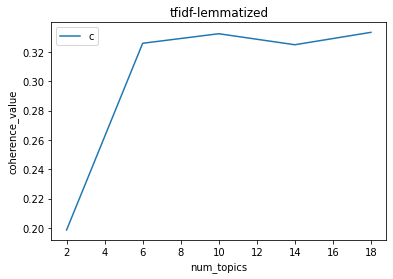

In [66]:
plot_cv_per_topic(lda_mallet_tfidf_lemma_cv_list, 'tfidf-lemmatized')

In [67]:
print_cv_per_topic(lda_mallet_tfidf_lemma_cv_list)

num_topics: 2 has Coherence Value: 0.1986
num_topics: 6 has Coherence Value: 0.3258
num_topics: 10 has Coherence Value: 0.3323
num_topics: 14 has Coherence Value: 0.3248
num_topics: 18 has Coherence Value: 0.3333


In [68]:
### LDA mallet on stemmed comments
# Can take a long time to run.
start = time.time()
lda_mallet_tfidf_stem_mod_list, lda_mallet_tfidf_stem_cv_list = compute_cv(
    dictionary=dictionary_s, 
    corpus=vectorized_corpus_s,
    corpus_type='tfidf-stemmed',
    texts=data.stemmed_comment)
print('Total time:', round(time.time()-start, 2))

Computing Coherence Values for LDA Mallet models using tfidf-stemmed corpus...
 - num_topics: 2
 --  122.29 s
 - num_topics: 6
 --  113.05 s
 - num_topics: 10
 --  228.19 s
 - num_topics: 14
 --  183.61 s
 - num_topics: 18
 --  159.54 s
Total time: 964.53


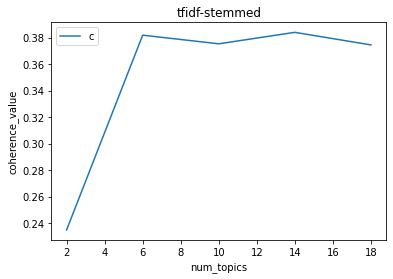

In [69]:
plot_cv_per_topic(lda_mallet_tfidf_stem_cv_list, 'tfidf-stemmed')

In [70]:
print_cv_per_topic(lda_mallet_tfidf_stem_cv_list)

num_topics: 2 has Coherence Value: 0.2347
num_topics: 6 has Coherence Value: 0.3818
num_topics: 10 has Coherence Value: 0.3753
num_topics: 14 has Coherence Value: 0.3839
num_topics: 18 has Coherence Value: 0.3744


#### LDA Mallet on BoW corpus

In [71]:
# Can take a long time to run.
start = time.time()
lda_mallet_bow_lemma_mod_list, lda_mallet_bow_lemma_cv_list = compute_cv(
    dictionary=dictionary_l, 
    corpus=corpus_l,
    corpus_type='bow-lemmatized',
    texts=data.lemmatized_comment)
print('Total time:', round(time.time()-start, 2))

Computing Coherence Values for LDA Mallet models using bow-lemmatized corpus...
 - num_topics: 2
 --  157.44 s
 - num_topics: 6
 --  152.46 s
 - num_topics: 10
 --  191.53 s
 - num_topics: 14
 --  194.46 s
 - num_topics: 18
 --  201.57 s
Total time: 984.02


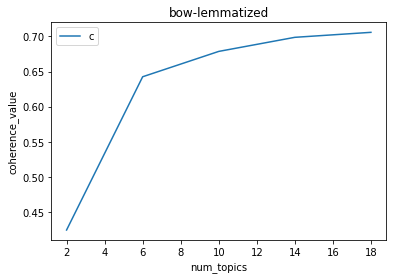

In [72]:
plot_cv_per_topic(lda_mallet_bow_lemma_cv_list, 'bow-lemmatized')

In [73]:
print_cv_per_topic(lda_mallet_bow_lemma_cv_list)

num_topics: 2 has Coherence Value: 0.4248
num_topics: 6 has Coherence Value: 0.6426
num_topics: 10 has Coherence Value: 0.6786
num_topics: 14 has Coherence Value: 0.6986
num_topics: 18 has Coherence Value: 0.7057


In [74]:
# Can take a long time to run.
start = time.time()
lda_mallet_bow_stem_mod_list, lda_mallet_bow_stem_cv_list = compute_cv(
    dictionary=dictionary_s, 
    corpus=corpus_s,
    corpus_type='bow-stemmed',
    texts=data.stemmed_comment)
print('Total time:', round(time.time()-start, 2))

Computing Coherence Values for LDA Mallet models using bow-stemmed corpus...
 - num_topics: 2
 --  134.64 s
 - num_topics: 6
 --  159.56 s
 - num_topics: 10
 --  199.83 s
 - num_topics: 14
 --  221.22 s
 - num_topics: 18
 --  206.07 s
Total time: 1018.65


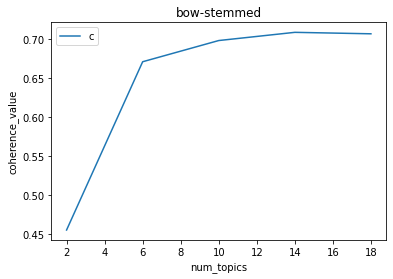

In [75]:
plot_cv_per_topic(lda_mallet_bow_stem_cv_list, 'bow-stemmed')

In [76]:
print_cv_per_topic(lda_mallet_bow_stem_cv_list)

num_topics: 2 has Coherence Value: 0.4552
num_topics: 6 has Coherence Value: 0.6711
num_topics: 10 has Coherence Value: 0.6983
num_topics: 14 has Coherence Value: 0.7088
num_topics: 18 has Coherence Value: 0.707


___

## Finding the dominant topic in each document

To determine what topic a given document(comment) is about, we find the topic number that has the highest percentage contribution in that document

In [77]:
def format_doc_topics(model, corpus, texts):
    # init output
    doc_topics = pd.DataFrame()
    
    # get main topic in each document
    for i, row in enumerate(model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # get document topic, % contribution and keywords for each doc
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # -> dominant topic
                wp = model.show_topic(topic_num)
                topic_keywords = ','.join([word for word, prop in wp])
                doc_topics = doc_topics.append(
                    pd.Series([int(topic_num),
                               round(prop_topic, 4),
                               topic_keywords]), ignore_index=True)
            else:
                break
    doc_topics.columns = ['dominant_topic', 'contrib_pct', 'topic_keywords']
    
    # Add original text to the end of the output
    contents = pd.Series(texts)
    doc_topics = pd.concat([doc_topics, contents], axis=1)
    return doc_topics

In [78]:
topics_keywords_tfidf_stem = format_doc_topics(model=lda_tfidf_stem_mod,
                                               corpus=vectorized_corpus_s,
                                               texts=data.comment) # original comment  

# format
dominant_topic_tfidf_stem = topics_keywords_tfidf_stem.reset_index()
dominant_topic_tfidf_stem.columns = ['doc_no', 'dominant_topic',
                                     'topic_contrib_pct', 'keywords', 'text']

# display        
dominant_topic_tfidf_stem

,doc_no,dominant_topic,topic_contrib_pct,keywords,text
0,0,3.0,0.4024,"github,link,video,youtub,watch,file,open,git,f...",build logic plugin
1,1,6.0,0.5608,"server,user,password,window,email,secur,access...",thread cloud prem infra responding context
2,2,1.0,0.6449,"china,countri,govern,car,chines,law,compani,ne...",technologyconversations podcast episodes
3,3,6.0,0.6214,"server,user,password,window,email,secur,access...",ecosystem evolved greatly jenkins hayday chang...
4,4,0.0,0.7356,"job,compani,manag,work,learn,team,secur,pay,ex...",learning techs teaching developer advocacy pos...
...,...,...,...,...,...
323593,323593,6.0,0.7084,"server,user,password,window,email,secur,access...",turns 16 rhel licenses led oooooh
323594,323594,0.0,0.7132,"job,compani,manag,work,learn,team,secur,pay,ex...",telecomix exist helped situation ago
323595,323595,3.0,0.5713,"github,link,video,youtub,watch,file,open,git,f...",viewers
323596,323596,4.0,0.6436,"switch,network,connect,port,router,rout,firewa...",straight forward


## Finding the more representative document for each topic

Sometimes just the topic keywords may not be enough to make sense of what the topic is.
Hence we can find the documents a given topic has contributed to the most and infer the topic by reading that document

In [79]:
# Group top 5 comments under each topic
topics_sorted_tfidf_stem = pd.DataFrame()

topics_out_tfidf_stem_grpd = topics_keywords_tfidf_stem.groupby('dominant_topic')

for i, grp in topics_out_tfidf_stem_grpd:
    topics_sorted_tfidf_stem = pd.concat([topics_sorted_tfidf_stem,
                                          grp.sort_values(['contrib_pct'], ascending=[0]).head(1)],
                                         axis=0)

# Reset index
topics_sorted_tfidf_stem.reset_index(drop=True, inplace=True)

# Format
topics_sorted_tfidf_stem.columns = ['topic_num', 'topic_contrib_pct', 'keywords', 'text']

# Display
topics_sorted_tfidf_stem

,topic_num,topic_contrib_pct,keywords,text
0,0.0,0.8830,"job,compani,manag,work,learn,team,secur,pay,ex...",asked learn knowledge real projects future con...
1,1.0,0.8272,"china,countri,govern,car,chines,law,compani,ne...",afford throw couple billions supply chain bott...
2,2.0,0.8886,"game,price,card,intel,perform,core,gpu,amd,buy...",curious m1 costs apple compared buying intel c...
3,3.0,0.8349,"github,link,video,youtub,watch,file,open,git,f...",complexcolor code blocks backticks versions re...
4,4.0,0.8743,"switch,network,connect,port,router,rout,firewa...",brought business ccna driving nuts month windo...
5,5.0,0.8994,"code,languag,data,read,post,python,write,comme...",bit hung throws original post open throws pote...
6,6.0,0.8838,"server,user,password,window,email,secur,access...",setting proper chroots ssh trivial imo copy mo...


## Topic Distribution

Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed

In [80]:
# Number of docs per topic
topic_counts_tfidf_stem = topics_keywords_tfidf_stem.dominant_topic.value_counts()

# Percentage of docs per topic
topic_contrib_tfidf_stem = round(topic_counts_tfidf_stem/topic_counts_tfidf_stem.sum(), 4)

# Topic number and keywords
topic_num_keywords_tfidf_stem = topics_keywords_tfidf_stem[['dominant_topic', 'topic_keywords']]

# Concatenate column wise
dominant_topics_tfidf_stem = pd.concat([topic_num_keywords_tfidf_stem, 
                                        topic_counts_tfidf_stem, 
                                        topic_contrib_tfidf_stem], 
                                       axis=1)

# Change column names
dominant_topics_tfidf_stem.columns = ['dominant_topic', 'topic_keywords', 'num_docs', 'perc_docs']

# Display
dominant_topics_tfidf_stem

,dominant_topic,topic_keywords,num_docs,perc_docs
0.0,3.0,"github,link,video,youtub,watch,file,open,git,f...",73544.0,0.2273
1.0,6.0,"server,user,password,window,email,secur,access...",16012.0,0.0495
2.0,1.0,"china,countri,govern,car,chines,law,compani,ne...",57517.0,0.1777
3.0,6.0,"server,user,password,window,email,secur,access...",17960.0,0.0555
4.0,0.0,"job,compani,manag,work,learn,team,secur,pay,ex...",31579.0,0.0976
...,...,...,...,...
323593.0,6.0,"server,user,password,window,email,secur,access...",NaN,NaN
323594.0,0.0,"job,compani,manag,work,learn,team,secur,pay,ex...",NaN,NaN
323595.0,3.0,"github,link,video,youtub,watch,file,open,git,f...",NaN,NaN
323596.0,4.0,"switch,network,connect,port,router,rout,firewa...",NaN,NaN


In [82]:
dominant_topics_tfidf_stem.head(10)

,dominant_topic,topic_keywords,num_docs,perc_docs
0.0,3.0,"github,link,video,youtub,watch,file,open,git,f...",73544.0,0.2273
1.0,6.0,"server,user,password,window,email,secur,access...",16012.0,0.0495
2.0,1.0,"china,countri,govern,car,chines,law,compani,ne...",57517.0,0.1777
3.0,6.0,"server,user,password,window,email,secur,access...",17960.0,0.0555
4.0,0.0,"job,compani,manag,work,learn,team,secur,pay,ex...",31579.0,0.0976
5.0,6.0,"server,user,password,window,email,secur,access...",66786.0,0.2064
6.0,0.0,"job,compani,manag,work,learn,team,secur,pay,ex...",60200.0,0.1860
7.0,3.0,"github,link,video,youtub,watch,file,open,git,f...",NaN,NaN
8.0,0.0,"job,compani,manag,work,learn,team,secur,pay,ex...",NaN,NaN
9.0,1.0,"china,countri,govern,car,chines,law,compani,ne...",NaN,NaN


____

# Combining comments under the same title (post)

In [18]:
data.head()

,comment,title,subreddit,score,comment_len
0,company original instance container docker swa...,building jenkins pipeline,devops,2,1551
1,analogy breaks actively maintained jenkins hor...,building jenkins pipeline,devops,2,132
2,solutions architecture customer engineering pe...,industries life devops,devops,3,210
3,moved jenkins helm jenkins operator working au...,building jenkins pipeline,devops,1,142
4,unsure open moving based profit hospital perso...,industries life devops,devops,3,210


In [20]:
data.title

0                                 building jenkins pipeline
1                                 building jenkins pipeline
2                                    industries life devops
3                                 building jenkins pipeline
4                                    industries life devops
                                ...                        
417949                              staff desktop computers
417950    rocket lake microcode offers performance gains...
417951                           thoughts password managers
417952                      leaning networking journey life
417953    asahi linux progress report porting linux appl...
Name: title, Length: 417954, dtype: object

In [21]:
df_grouped = data.groupby(['title'])#['comment'].transform(lambda x: ' '.join(x))

In [227]:
# df_grouped.get_group('building jenkins pipeline')

In [228]:
# df_grouped.get_group('2020 biggest devops')

In [22]:
' '.join(df_grouped.get_group('industries life devops').comment)

'solutions architecture customer engineering perfect customer facing skills develop wider view tech landscape roles stay technical build demos pocs daily project implementation grind cloud providers hiring roles unsure open moving based profit hospital personally children hospital morning areas expertise needed hospital vast genome sequencing infrastructure engineers devops data scientists working bunch everyday humans sounds tightening belt investing business learning techs teaching developer advocacy positions swing architect role grinding story points mention number roles step ladder easier nailed progression upward forward interested lateral architect position attractive avenue search hesitant deeply healthcare experience medical device companies wheel spinning glad hear brighter opportunities recruited role skeptical concerns dm cheers'

In [23]:
titles = list(df_grouped.groups.keys())
all_comments = []
for title in titles:
    # combine all comments - prepend title
    title_comments = title + ' ' + ' '.join(
        df_grouped.get_group(title).comment)
    all_comments.append(title_comments)

In [24]:
len(all_comments)

27016

In [27]:
df_agg = pd.DataFrame({
    'title':titles,
    'text': all_comments})

In [28]:
df_agg.head()

,title,text
0,00 google hold notifications card google subs,00 google hold notifications card google subs ...
1,0365 email accounts,0365 email accounts block powershell access ad...
2,0365 roll critical account protection accounts...,0365 roll critical account protection accounts...
3,06 secret history windows zipfolders original ...,06 secret history windows zipfolders original ...
4,10 000 double pendulums double pendulum simula...,10 000 double pendulums double pendulum simula...


In [29]:
df_agg.text[0]

'00 google hold notifications card google subs called citibank safe wait alerts suspicious plenty dispute cancel card 4 charges today odd credit card remember straight update card details domain registrars assume compromised testing card dumbshitontheright report card lost stolen'

In [63]:
tokenized_text = list(tokenize(df_agg.text))
df_agg['tokens'] = tokenized_text
print('Tokenized:\n', df_agg.tokens[0])

# Remove stopwords
nostops_text = remove_stopwords(df_agg.tokens)
print('\nWithout stopwords:\n', nostops_text[0])
df_agg['tokens'] = nostops_text # replace with clean tokenized

# Form bigrams and trigrams
bigram = Phrases(df_agg.tokens, min_count=3, threshold=10) # higher threshold fewer places
bigram_mod = Phraser(bigram)
print('\nBigram:\n', bigram[df_agg.tokens[0]])
df_agg['bigram'] = [bigram_mod[doc] for doc in df_agg.tokens]

trigram = Phrases(bigram[df_agg.tokens], threshold=10) # higher threshold fewer places
trigram_mod = Phraser(trigram)
print('\nTrigram:\n', trigram[df_agg.tokens[0]])
df_agg['trigram'] = [trigram_mod[bigram_mod[doc]] for doc in df_agg.tokens]

# Snowball stemmer
stemmed_text = stemming(df_agg.tokens, 'snow')
df_agg['stem_text'] = stemmed_text 
df_agg['stem_bi'] = stemming(df_agg.bigram, 'snow')
df_agg['stem_tri'] = stemming(df_agg.trigram, 'snow')
print('\nStemmed:\n', stemmed_text[0])


# Lemmatization
lemmatized_text = lemmatization(df_agg.tokens)
print('\nLemmatized:\n', lemmatized_text[0])
df_agg['lemma_text'] = lemmatized_text
df_agg['lemma_bi'] = lemmatization(df_agg.bigram)
df_agg['lemma_tri'] = lemmatization(df_agg.trigram)

Tokenized:
 ['google', 'hold', 'notifications', 'card', 'google', 'subs', 'called', 'citibank', 'safe', 'wait', 'alerts', 'suspicious', 'plenty', 'dispute', 'cancel', 'card', 'charges', 'today', 'odd', 'credit', 'card', 'remember', 'straight', 'update', 'card', 'details', 'domain', 'registrars', 'assume', 'compromised', 'testing', 'card', 'report', 'card', 'lost', 'stolen']

Without stopwords:
 ['google', 'hold', 'notifications', 'card', 'google', 'subs', 'called', 'citibank', 'safe', 'wait', 'alerts', 'suspicious', 'plenty', 'dispute', 'cancel', 'card', 'charges', 'today', 'odd', 'credit', 'card', 'remember', 'straight', 'update', 'card', 'details', 'domain', 'registrars', 'assume', 'compromised', 'testing', 'card', 'report', 'card', 'lost', 'stolen']

Bigram:
 ['google', 'hold', 'notifications', 'card', 'google', 'subs', 'called', 'citibank', 'safe', 'wait', 'alerts', 'suspicious', 'plenty', 'dispute', 'cancel', 'card', 'charges', 'today', 'odd', 'credit_card', 'remember', 'straight'

### Create dictionary, corpus and vectorized corpus needed for Topic modeling

In [72]:
df_agg.head()

,title,text,tokenized_text,bigram,stemmed_text,lemmatized_text,tokens,trigram,stem_text,stem_bi,stem_tri,lemma_text,lemma_bi,lemma_tri
0,00 google hold notifications card google subs,00 google hold notifications card google subs ...,"[google, hold, notifications, card, google, su...","[google, hold, notifications, card, google, su...","[googl, hold, notif, card, googl, sub, call, c...","[google, hold, notification, card, google, sub...","[google, hold, notifications, card, google, su...","[google, hold, notifications, card, google, su...","[googl, hold, notif, card, googl, sub, call, c...","[googl, hold, notif, card, googl, sub, call, c...","[googl, hold, notif, card, googl, sub, call, c...","[google, hold, notification, card, google, sub...","[google, hold, notification, card, google, sub...","[google, hold, notification, card, google, sub..."
1,0365 email accounts,0365 email accounts block powershell access ad...,"[email, accounts, block, powershell, access, a...","[email_accounts, block, powershell, access, ad...","[email, account, block, powershel, access, adm...","[email, account, block, powershell, access, ad...","[email, accounts, block, powershell, access, a...","[email_accounts, block, powershell, access, ad...","[email, account, block, powershel, access, adm...","[email_account, block, powershel, access, admi...","[email_account, block, powershel, access, admi...","[email, account, block, powershell, access, ad...","[email_accounts, block, powershell, access, ad...","[email_accounts, block, powershell, access, ad..."
2,0365 roll critical account protection accounts...,0365 roll critical account protection accounts...,"[roll, critical, account, protection, accounts...","[roll, critical, account, protection, accounts...","[roll, critic, account, protect, account, high...","[roll, critical, account, protection, account,...","[roll, critical, account, protection, accounts...","[roll, critical, account, protection, accounts...","[roll, critic, account, protect, account, high...","[roll, critic, account, protect, account, high...","[roll, critic, account, protect, account, high...","[roll, critical, account, protection, account,...","[roll, critical, account, protection, account,...","[roll, critical, account, protection, account,..."
3,06 secret history windows zipfolders original ...,06 secret history windows zipfolders original ...,"[secret, history, windows, zipfolders, origina...","[secret_history, windows, zipfolders, original...","[secret, histori, window, zipfold, origin, aut...","[secret, history, window, zipfolders, original...","[secret, history, windows, zipfolders, origina...","[secret_history_windows, zipfolders, original_...","[secret, histori, window, zipfold, origin, aut...","[secret_histori, window, zipfold, original_aut...","[secret_history_window, zipfold, original_auth...","[secret, history, window, zipfolders, original...","[secret_history, window, zipfolders, original_...","[secret_history_windows, zipfolders, original_..."
4,10 000 double pendulums double pendulum simula...,10 000 double pendulums double pendulum simula...,"[double, pendulums, double, pendulum, simulati...","[double_pendulums, double_pendulum, simulation...","[doubl, pendulum, doubl, pendulum, simul, shar...","[double, pendulum, double, pendulum, simulatio...","[double, pendulums, double, pendulum, simulati...","[double_pendulums, double_pendulum, simulation...","[doubl, pendulum, doubl, pendulum, simul, shar...","[double_pendulum, double_pendulum, simul, shar...","[double_pendulum, double_pendulum, simul, shar...","[double, pendulum, double, pendulum, simulatio...","[double_pendulums, double_pendulum, simulation...","[double_pendulums, double_pendulum, simulation..."


In [64]:
# Create dictionary representation of the documents
dict_stem = corpora.Dictionary(df_agg.stem_text)
dict_stem_bi = corpora.Dictionary(df_agg.stem_bi)
dict_stem_tri = corpora.Dictionary(df_agg.stem_tri)

dict_lemma = corpora.Dictionary(df_agg.lemma_text)
dict_lemma_bi = corpora.Dictionary(df_agg.lemma_bi)
dict_lemma_tri = corpora.Dictionary(df_agg.lemma_tri)

In [65]:
# Filter out words that occur in less than 20% documents, and above 50% documents
dict_stem.filter_extremes(no_below=20, no_above=0.5)
dict_stem_bi.filter_extremes(no_below=20, no_above=0.5)
dict_stem_tri.filter_extremes(no_below=20, no_above=0.5)

dict_lemma.filter_extremes(no_below=20, no_above=0.5)
dict_lemma_bi.filter_extremes(no_below=20, no_above=0.5)
dict_lemma_tri.filter_extremes(no_below=20, no_above=0.5)

In [66]:
print(dict_stem_bi[15])
print(dict_lemma_bi[15])

plenti
remember


In [67]:
# Bag of words
corpus_stem = [dict_stem.doc2bow(text) for text in df_agg.stem_text]
corpus_stem_bi = [dict_stem_bi.doc2bow(text) for text in df_agg.stem_bi]
corpus_stem_tri = [dict_stem_tri.doc2bow(text) for text in df_agg.stem_tri]

corpus_lemma = [dict_lemma.doc2bow(text) for text in df_agg.lemma_text]
corpus_lemma_bi = [dict_lemma_bi.doc2bow(text) for text in df_agg.lemma_bi]
corpus_lemma_tri = [dict_lemma_tri.doc2bow(text) for text in df_agg.lemma_tri]

In [68]:
print(corpus_stem_bi[:2])
print(corpus_lemma_bi[:2])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 5), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)], [(6, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 2), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1)]]
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 5), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1)], [(25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53,

In [69]:
# Human readable form of the BoW
print([[(dict_stem_bi[id], freq) for id, freq in word] for word in corpus_stem_bi[:2]])
print([[(dict_lemma_bi[id], freq) for id, freq in word] for word in corpus_lemma_bi[:2]])


[[('alert', 1), ('assum', 1), ('call', 1), ('cancel', 1), ('card', 5), ('charg', 1), ('compromis', 1), ('credit_card', 1), ('detail', 1), ('disput', 1), ('domain_registrar', 1), ('googl', 2), ('hold', 1), ('notif', 1), ('odd', 1), ('plenti', 1), ('rememb', 1), ('report', 1), ('safe', 1), ('straight', 1), ('sub', 1), ('suspici', 1), ('test', 1), ('today', 1), ('updat', 1), ('wait', 1)], [('compromis', 1), ('access', 1), ('add', 1), ('admin_account', 1), ('attack', 1), ('auto', 1), ('block', 1), ('compris', 1), ('configur', 1), ('credenti', 1), ('defend', 1), ('disabl', 1), ('edit', 1), ('email_account', 1), ('exchange_onlin', 1), ('forc', 1), ('forward', 1), ('hafnium', 2), ('histori', 1), ('implement', 1), ('june', 1), ('legaci', 2), ('mfa', 1), ('offic', 1), ('password', 1), ('password_reset', 1), ('plan', 1), ('powershel', 1), ('prem_exchang', 1), ('restrict', 1), ('rule', 1), ('stuf', 1), ('vector', 1)]]
[[('alert', 1), ('assume', 1), ('called', 1), ('cancel', 1), ('card', 5), ('cha

In [70]:
# Compute TF-IDF score for each word in BoW (stemmed corpus)
tfidf_mod_stem = TfidfModel(corpus_stem, normalize=True)
vec_corpus_stem = tfidf_mod_stem[corpus_stem]

tfidf_mod_stem_bi = TfidfModel(corpus_stem_bi, normalize=True)
vec_corpus_stem_bi = tfidf_mod_stem[corpus_stem_bi]

tfidf_mod_stem_tri = TfidfModel(corpus_stem_tri, normalize=True)
vec_corpus_stem_tri = tfidf_mod_stem[corpus_stem_tri]


# Compute TF-IDF score for each word in BoW ( lemmatized corpus)
tfidf_mod_lemma = TfidfModel(corpus_lemma, normalize=True)
vec_corpus_lemma = tfidf_mod_lemma[corpus_lemma]

tfidf_mod_lemma_bi = TfidfModel(corpus_lemma_bi, normalize=True)
vec_corpus_lemma_bi = tfidf_mod_lemma[corpus_lemma_bi]

tfidf_mod_lemma_tri = TfidfModel(corpus_lemma_tri, normalize=True)
vec_corpus_lemma_tri = tfidf_mod_lemma[corpus_lemma_tri]

In [71]:
print(tfidf_mod_stem_bi[vec_corpus_stem_bi[0]])
print(tfidf_mod_lemma_bi[vec_corpus_lemma_bi[0]])

[(0, 0.1784668839862196), (1, 0.06165833278624859), (2, 0.058614005442056506), (3, 0.251528117218195), (4, 0.5228684979409685), (5, 0.1369281796723023), (6, 0.1393171865490319), (7, 0.2341989484992269), (8, 0.09211314297693372), (9, 0.36502336365075255), (10, 0.22567362212585673), (11, 0.1244863861486516), (12, 0.10411145592507183), (13, 0.16743382694884615), (14, 0.17873564188212482), (15, 0.12736198148397904), (16, 0.08991823202412697), (17, 0.21042252165797246), (18, 0.09312517979506585), (19, 0.10653175954846365), (20, 0.18889745385956977), (21, 0.2795603928235537), (22, 0.07637349240737959), (23, 0.16282350300055054), (24, 0.11968375627970551), (25, 0.0562528518089089)]
[(0, 0.18478508741000987), (1, 0.09366479757464867), (2, 0.07632550278388446), (3, 0.31830549039720496), (4, 0.5000640385668317), (5, 0.14704365912051054), (6, 0.1794292173669439), (7, 0.22513476336616525), (8, 0.10462490556294024), (9, 0.38671586694968335), (10, 0.14129254864525162), (11, 0.08350437382661656), (12

### Building the topic model

#### LDA on TF_IDF

In [246]:
# lemmatized corpus
lda_tfidf_lemma_mod = build_lda(
    corpus=vec_corpus_lemma,
    dictionary=dict_lemma,
    corpus_type='tfidf-lemma',
    num_topics=7,
    texts=df_agg.lemmatized_text)

Building LDA model using tfidf-lemmatized corpus...
 - 230.2766s

Topic 1:  Words: 0.005*"inf" + 0.005*"dmca" + 0.004*"vsan" + 0.003*"takedown" + 0.003*"sscp" + 0.003*"squid" + 0.003*"bundle" + 0.002*"jason" + 0.002*"vid" + 0.002*"ama"
Topic 2:  Words: 0.010*"amd" + 0.010*"nvidia" + 0.009*"card" + 0.008*"intel" + 0.008*"gpu" + 0.007*"price" + 0.006*"game" + 0.006*"nm" + 0.006*"chip" + 0.006*"rtx"
Topic 3:  Words: 0.015*"wvd" + 0.009*"pdq" + 0.008*"ntp" + 0.005*"pulseway" + 0.005*"jumpcloud" + 0.004*"anydesk" + 0.004*"fslogix" + 0.003*"year" + 0.003*"vnc" + 0.003*"teamviewer"
Topic 4:  Words: 0.008*"devops" + 0.007*"cert" + 0.007*"security" + 0.006*"docker" + 0.006*"cyber" + 0.006*"degree" + 0.005*"cybersecurity" + 0.005*"job" + 0.005*"learn" + 0.005*"aws"
Topic 5:  Words: 0.003*"company" + 0.002*"network" + 0.002*"job" + 0.002*"switch" + 0.002*"security" + 0.002*"router" + 0.002*"team" + 0.002*"day" + 0.002*"device" + 0.002*"port"
Topic 6:  Words: 0.005*"code" + 0.004*"language" + 0.00

In [247]:
pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim.prepare(lda_tfidf_lemma_agg_mod, vec_corpus_agg_l, dict_agg_l)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.052411 -0.035658       1        1  43.653748
5      0.030864  0.009340       2        1  20.642216
6      0.178387 -0.146598       3        1  18.367470
3      0.139634  0.166136       4        1   7.780047
1     -0.187783 -0.065019       5        1   5.609868
2     -0.110296  0.037483       6        1   2.009452
0     -0.103216  0.034315       7        1   1.937209, topic_info=              Term        Freq       Total Category  logprob  loglift
2369      password  228.000000  228.000000  Default  30.0000  30.0000
4             card  143.000000  143.000000  Default  29.0000  29.0000
1591      security  297.000000  297.000000  Default  28.0000  28.0000
772            amd  111.000000  111.000000  Default  27.0000  27.0000
2050        devops  118.000000  118.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
5641        humble    4.449254    9.405292   Topic7  -6.5269   3.1954
140         bundle    7.675443   21.878662   Topic7  -5.9816   2.8964
13483  pluralsight    3.719217    8.800606   Topic7  -6.7062   3.0826
12901      sidebar    3.872759   17.513741   Topic7  -6.6657   2.4349
8272         snort    3.200397    8.910817   Topic7  -6.8564   2.9199

[450 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
5527       3  0.941519      aad
2473       1  0.461646   access
2473       2  0.045039   access
2473       3  0.484166   access
2473       4  0.005630   access
...      ...       ...      ...
7632       5  0.932548    zotac
11130      1  0.030418  zscaler
11130      3  0.942967  zscaler
10180      4  0.923190      zsh
3346       1  0.966164    zyxel

[973 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 7, 4, 2, 3, 1])

In [73]:
# stemmed corpus
lda_tfidf_stem_mod = build_lda(
    corpus=vec_corpus_stem,
    dictionary=dict_stem,
    corpus_type='tfidf-stem',
    texts=df_agg.stem_text,
    num_topics=7)

Building LDA model using tfidf-stem corpus...
 - 255.1402s

Topic 1:  Words: 0.008*"intel" + 0.008*"amd" + 0.008*"card" + 0.007*"nvidia" + 0.007*"gpu" + 0.006*"cpu" + 0.006*"gb" + 0.006*"price" + 0.006*"laptop" + 0.006*"core"
Topic 2:  Words: 0.003*"code" + 0.003*"data" + 0.003*"compani" + 0.002*"model" + 0.002*"learn" + 0.002*"languag" + 0.002*"program" + 0.002*"paper" + 0.002*"project" + 0.002*"problem"
Topic 3:  Words: 0.020*"cabl" + 0.010*"switch" + 0.010*"fiber" + 0.008*"wireless" + 0.007*"usb" + 0.007*"wifi" + 0.007*"sfp" + 0.007*"ethernet" + 0.007*"monitor" + 0.007*"port"
Topic 4:  Words: 0.009*"wvd" + 0.008*"teamview" + 0.008*"whatsapp" + 0.007*"connectwis" + 0.006*"anydesk" + 0.006*"cve" + 0.005*"telegram" + 0.005*"spotifi" + 0.004*"galleri" + 0.003*"screenconnect"
Topic 5:  Words: 0.008*"password" + 0.007*"network" + 0.007*"vpn" + 0.007*"router" + 0.006*"port" + 0.006*"vlan" + 0.006*"firewal" + 0.006*"dns" + 0.006*"connect" + 0.006*"devic"
Topic 6:  Words: 0.008*"secur" + 0.0

In [76]:
pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim.prepare(lda_tfidf_stem_mod, vec_corpus_agg_s, dict_agg_s)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.036169  0.054218       1        1  49.709747
4     -0.097165 -0.027709       2        1  13.857669
6     -0.182501 -0.070551       3        1  11.008478
5     -0.127646  0.114190       4        1  10.802135
0      0.092644 -0.196197       5        1   9.138058
2      0.205043  0.012968       6        1   3.429331
3      0.145795  0.113081       7        1   2.054578, topic_info=          Term        Freq       Total Category  logprob  loglift
1539      cabl  142.000000  142.000000  Default  30.0000  30.0000
1014    switch  251.000000  251.000000  Default  29.0000  29.0000
64        user  349.000000  349.000000  Default  28.0000  28.0000
115     window  347.000000  347.000000  Default  27.0000  27.0000
806     server  421.000000  421.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
6512  whatsapp   27.139647   44.701401   Topic7  -4.8355   3.3861
7792       cve   20.685476   36.212303   Topic7  -5.1071   3.3251
4230      aspx    8.400708   19.551218   Topic7  -6.0082   3.0404
5079     oauth    7.354167   17.559757   Topic7  -6.1412   3.0148
5982        sp    5.376119   10.920263   Topic7  -6.4545   3.1764

[469 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4648      2  0.041281      aad
4648      3  0.949459      aad
29        1  0.283427   access
29        2  0.347842   access
29        3  0.309193   access
...     ...       ...      ...
8326      7  0.981027      wvd
793       5  0.971123       xt
3046      2  0.023355      zen
3046      5  0.957543      zen
8613      2  0.922190  zscaler

[1160 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 7, 6, 1, 3, 4])

In [77]:
# 2 topic - stemmed corpus
lda_tfidf_stem_2top_mod = build_lda(
    corpus=vec_corpus_stem,
    dictionary=dict_stem,
    corpus_type='tfidf-stem',
    texts=df_agg.stem_text,
    num_topics=2)

Building LDA model using tfidf-stem corpus...
 - 242.9653s

Topic 1:  Words: 0.003*"learn" + 0.003*"code" + 0.003*"job" + 0.003*"compani" + 0.002*"secur" + 0.002*"program" + 0.002*"model" + 0.002*"languag" + 0.002*"project" + 0.002*"game"
Topic 2:  Words: 0.006*"server" + 0.005*"window" + 0.005*"user" + 0.004*"file" + 0.004*"password" + 0.004*"network" + 0.003*"connect" + 0.003*"devic" + 0.003*"instal" + 0.003*"updat"

- Perplexity: -8.5189
- Coherence Score: 0.4316


In [78]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_stem_2top_mod, vec_corpus_agg_s, dict_agg_s)
viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.120787  0.0       1        1  57.013096
1     -0.120787  0.0       2        1  42.986904, topic_info=          Term        Freq       Total Category  logprob  loglift
806     server  423.000000  423.000000  Default  30.0000  30.0000
115     window  348.000000  348.000000  Default  29.0000  29.0000
55    password  284.000000  284.000000  Default  28.0000  28.0000
882       file  292.000000  292.000000  Default  27.0000  27.0000
64        user  354.000000  354.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
777        set  210.050034  264.509277   Topic2  -5.8300   0.6137
819        app  189.386627  230.655914   Topic2  -5.9335   0.6471
97       manag  196.377472  309.093567   Topic2  -5.8973   0.3907
188      check  163.793610  224.250565   Topic2  -6.0787   0.5301
1371     secur  171.792099  399.969604   Topic2  -6.0310  -0.0008

[158 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
29        1  0.089093   access
29        2  0.912139   access
30        1  0.094586  account
30        2  0.902871  account
1061      1  0.044832  address
...     ...       ...      ...
1438      2  0.998880      vpn
115       1  0.028702   window
115       2  0.970135   window
791       1  0.509350     work
791       2  0.491288     work

[248 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [79]:
# stem-bi corpus
lda_tfidf_stem_bi_mod = build_lda(
    corpus=vec_corpus_stem_bi,
    dictionary=dict_stem_bi,
    corpus_type='tfidf-stem-bi',
    texts=df_agg.stem_bi,
    num_topics=7)

Building LDA model using tfidf-stem-bi corpus...
 - 237.6374s

Topic 1:  Words: 0.010*"compani" + 0.005*"manag" + 0.005*"work" + 0.004*"chang" + 0.004*"support" + 0.004*"day" + 0.004*"site" + 0.004*"secur" + 0.003*"team" + 0.003*"start"
Topic 2:  Words: 0.015*"server" + 0.014*"network" + 0.010*"connect" + 0.007*"devic" + 0.007*"set" + 0.007*"port" + 0.007*"support" + 0.006*"rout" + 0.005*"switch" + 0.005*"traffic"
Topic 3:  Words: 0.019*"server" + 0.015*"window" + 0.013*"set" + 0.009*"updat" + 0.009*"user" + 0.007*"chang" + 0.007*"machin" + 0.006*"work" + 0.006*"file" + 0.006*"microsoft"
Topic 4:  Words: 0.003*"ama" + 0.002*"megathread" + 0.002*"deno" + 0.002*"black_friday" + 0.001*"npm_packag" + 0.001*"gcs" + 0.001*"cortana" + 0.001*"stress_test" + 0.001*"repost" + 0.001*"lang"
Topic 5:  Words: 0.011*"cpu" + 0.011*"price" + 0.011*"game" + 0.010*"intel" + 0.009*"chip" + 0.009*"perform" + 0.007*"power" + 0.006*"buy" + 0.006*"amd" + 0.005*"nvidia"
Topic 6:  Words: 0.013*"tool" + 0.010*"c

In [80]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_stem_bi_mod, vec_corpus_stem_bi, dict_stem_bi)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.049289  0.040462       1        1  35.463608
6      0.028100  0.048002       2        1  21.364622
1      0.085004  0.037418       3        1  15.239981
2      0.148660 -0.047893       4        1  11.045208
4     -0.132938  0.160681       5        1   9.087537
5      0.024236 -0.116241       6        1   5.822549
3     -0.202352 -0.122429       7        1   1.976490, topic_info=                Term        Freq       Total Category  logprob  loglift
769           server  998.000000  998.000000  Default  30.0000  30.0000
180             code  727.000000  727.000000  Default  29.0000  29.0000
1412            tool  447.000000  447.000000  Default  28.0000  28.0000
100           window  487.000000  487.000000  Default  27.0000  27.0000
1565         network  643.000000  643.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
11953        scrutin    0.212077    1.000834   Topic7  -9.6333   2.3722
3210   issues_resolv    0.215311    1.836849   Topic7  -9.6182   1.7801
7780           ditto    0.217843    3.310402   Topic7  -9.6065   1.2028
6286       repercuss    0.217718    3.776665   Topic7  -9.6071   1.0705
3581          raster    0.216941    5.869282   Topic7  -9.6107   0.6260

[525 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
5377       1  0.057721      aad
5377       4  0.923542      aad
58         1  0.549884  account
58         2  0.043991  account
58         3  0.030794  account
...      ...       ...      ...
6331       1  0.923980  yubikey
3266       1  0.034827      zen
3266       3  0.034827      zen
3266       5  0.940325      zen
10333      6  0.875570      zsh

[1316 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 2, 3, 5, 6, 4])

In [81]:
# 2topic - stem-bi corpus
lda_tfidf_stem_bi_2top_mod = build_lda(
    corpus=vec_corpus_stem_bi,
    dictionary=dict_stem_bi,
    corpus_type='tfidf-stem-bi',
    texts=df_agg.stem_bi,
    num_topics=2)

Building LDA model using tfidf-stem-bi corpus...
 - 222.0249s

Topic 1:  Words: 0.008*"code" + 0.005*"program" + 0.004*"compani" + 0.004*"develop" + 0.003*"power" + 0.003*"work" + 0.003*"problem" + 0.003*"case" + 0.003*"project" + 0.003*"price"
Topic 2:  Words: 0.012*"server" + 0.007*"network" + 0.007*"set" + 0.007*"manag" + 0.006*"work" + 0.006*"window" + 0.005*"support" + 0.005*"chang" + 0.005*"connect" + 0.005*"compani"

- Perplexity: -8.3143
- Coherence Score: 0.3174


In [82]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_stem_bi_2top_mod, vec_corpus_stem_bi, dict_stem_bi)
viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.102217  0.0       1        1  50.067307
0     -0.102217  0.0       2        1  49.932697, topic_info=         Term         Freq        Total Category  logprob  loglift
769    server  1009.000000  1009.000000  Default  30.0000  30.0000
1565  network   650.000000   650.000000  Default  29.0000  29.0000
729     manag   581.000000   581.000000  Default  28.0000  28.0000
180      code   739.000000   739.000000  Default  27.0000  27.0000
1361    secur   399.000000   399.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
528     sound   187.552368   391.433014   Topic2  -6.0778  -0.0413
152     build   182.392639   356.293091   Topic2  -6.1057   0.0249
556   support   201.874252   627.531128   Topic2  -6.0042  -0.4397
219       day   181.149139   364.176453   Topic2  -6.1126  -0.0038
163     chang   187.548584   600.479858   Topic2  -6.0779  -0.4692

[176 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
26        1  0.916698        access
26        2  0.083336        access
58        1  0.934843       account
58        2  0.066145       account
2125      1  0.993504         admin
...     ...       ...           ...
4338      2  0.014277  windows_serv
755       1  0.625543          work
755       2  0.373719          work
619       1  0.251340         write
619       2  0.749277         write

[267 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [87]:
# stem-tri corpus
lda_tfidf_stem_tri_mod = build_lda(
    corpus=vec_corpus_stem_tri,
    dictionary=dict_stem_tri,
    corpus_type='tfidf-stem-tri',
    texts=df_agg.stem_tri,
    num_topics=7)

Building LDA model using tfidf-stem-tri corpus...
 - 228.1680s

Topic 1:  Words: 0.010*"start" + 0.010*"manag" + 0.009*"compani" + 0.008*"job" + 0.007*"experi" + 0.007*"project" + 0.006*"learn" + 0.006*"work" + 0.005*"tool" + 0.005*"understand"
Topic 2:  Words: 0.006*"chrome" + 0.004*"shared_mailbox" + 0.003*"apach" + 0.003*"mozilla" + 0.003*"websit" + 0.003*"websocket" + 0.002*"pw" + 0.002*"password_protect" + 0.002*"master_password" + 0.002*"font"
Topic 3:  Words: 0.013*"code" + 0.008*"project" + 0.006*"python" + 0.005*"model" + 0.005*"data" + 0.005*"paper" + 0.005*"understand" + 0.004*"case" + 0.004*"start" + 0.004*"train"
Topic 4:  Words: 0.011*"window" + 0.010*"set" + 0.008*"server" + 0.008*"client" + 0.008*"manag" + 0.007*"instal" + 0.007*"run" + 0.006*"work" + 0.006*"user" + 0.006*"file"
Topic 5:  Words: 0.003*"pst" + 0.003*"moderators_subreddit_questions_concern" + 0.002*"action_performed_automatically_contact" + 0.002*"zdnet" + 0.002*"questionnair" + 0.002*"megathread" + 0.002

In [88]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_stem_tri_mod, vec_corpus_stem_tri, dict_stem_tri)
viz


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.101252  0.011408       1        1  32.795612
3      0.190914  0.129046       2        1  24.732151
0      0.133029 -0.056613       3        1  19.576292
2      0.120143 -0.110927       4        1  16.853754
1     -0.182973  0.013610       5        1   2.054767
4     -0.182456  0.007441       6        1   2.004033
5     -0.179908  0.006034       7        1   1.983395, topic_info=                 Term        Freq       Total Category  logprob  loglift
177              code  592.000000  592.000000  Default  30.0000  30.0000
467           project  503.000000  503.000000  Default  29.0000  29.0000
614            window  577.000000  577.000000  Default  28.0000  28.0000
727             manag  736.000000  736.000000  Default  27.0000  27.0000
84                job  340.000000  340.000000  Default  26.0000  26.0000
...               ...         ...         ...      ...      ...      ...
4559     readable_cod    0.212993    2.012336   Topic7  -9.6247   1.6746
10156            iclr    0.233645    6.748403   Topic7  -9.5321   0.5571
7984       crowdstrik    0.247715   14.559788   Topic7  -9.4737  -0.1534
10401  phishing_email    0.235676    8.728747   Topic7  -9.5235   0.3084
7002           cipher    0.235520   11.184362   Topic7  -9.5241   0.0599

[463 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1885      1  0.044907  abstract
1885      3  0.134720  abstract
1885      4  0.808321  abstract
4883      2  0.949333       acl
4883      3  0.039556       acl
...     ...       ...       ...
4262      1  0.459947       zip
4262      3  0.065707       zip
4262      5  0.394241       zip
4602      1  0.263030   zip_fil
4602      5  0.526060   zip_fil

[972 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 1, 3, 2, 5, 6])

In [85]:
# 2 topic - stem-tri corpus
lda_tfidf_stem_tri_2top_mod = build_lda(
    corpus=vec_corpus_stem_tri,
    dictionary=dict_stem_tri,
    corpus_type='tfidf-stem-tri',
    texts=df_agg.stem_tri,
    num_topics=2)

Building LDA model using tfidf-stem-tri corpus...
 - 215.0612s

Topic 1:  Words: 0.007*"set" + 0.006*"window" + 0.006*"manag" + 0.005*"run" + 0.005*"instal" + 0.005*"server" + 0.005*"client" + 0.004*"work" + 0.004*"email" + 0.004*"case"
Topic 2:  Words: 0.008*"code" + 0.007*"project" + 0.007*"start" + 0.005*"understand" + 0.005*"learn" + 0.005*"tool" + 0.005*"experi" + 0.004*"work" + 0.004*"compani" + 0.004*"job"

- Perplexity: -8.3704
- Coherence Score: 0.3686


In [86]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_stem_tri_2top_mod, vec_corpus_stem_tri, dict_stem_tri)
viz


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.099068  0.0       1        1  54.507317
1     -0.099068  0.0       2        1  45.492687, topic_info=         Term        Freq       Total Category  logprob  loglift
177      code  613.000000  613.000000  Default  30.0000  30.0000
467   project  521.000000  521.000000  Default  29.0000  29.0000
614    window  577.000000  577.000000  Default  28.0000  28.0000
367     learn  363.000000  363.000000  Default  27.0000  27.0000
971    server  425.000000  425.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
1361    secur  199.559006  388.692596   Topic2  -5.9148   0.1209
158      case  223.078125  562.865723   Topic2  -5.8034  -0.1379
727     manag  231.338974  750.446899   Topic2  -5.7670  -0.3892
1316  process  166.786148  309.118134   Topic2  -6.0942   0.1706
149     build  154.033630  235.893967   Topic2  -6.1738   0.3614

[162 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1885      2  0.983077      abstract
26        1  0.905128        access
26        2  0.096486        access
58        1  0.934344       account
58        2  0.065304       account
...     ...       ...           ...
4403      2  0.012554  windows_serv
752       1  0.538003          work
752       2  0.461950          work
617       1  0.125010         write
617       2  0.875068         write

[247 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [ ]:
# 2 topic - lemmatized corpus
lda_tfidf_lemma_2topic_agg_mod = build_lda(
    corpus=vec_corpus_agg_l,
    dictionary=dict_agg_l,
    corpus_type='tfidf-lemma-agg',
    num_topics=2,
    texts=df_agg.lemmatized_text)

In [ ]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_lemma_2topic_agg_mod, vec_corpus_agg_l, dict_agg_l)
viz

In [252]:
# 2 topic - stemmed corpus
lda_tfidf_stem_2topic_agg_mod = build_lda(
    corpus=vec_corpus_agg_s,
    dictionary=dict_agg_s,
    corpus_type='tfidf-stem-agg',
    num_topics=2,
    texts=df_agg.stemmed_text)

Building LDA model using tfidf-stemmed corpus...
 - 194.7319s

Topic 1:  Words: 0.005*"server" + 0.005*"secur" + 0.004*"window" + 0.004*"user" + 0.004*"network" + 0.004*"password" + 0.004*"file" + 0.003*"instal" + 0.003*"devic" + 0.003*"connect"
Topic 2:  Words: 0.004*"code" + 0.003*"learn" + 0.003*"job" + 0.003*"program" + 0.003*"languag" + 0.002*"model" + 0.002*"game" + 0.002*"write" + 0.002*"project" + 0.002*"compani"

- Perplexity: -8.5219
- Coherence Score: 0.4189


In [253]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_stem_2topic_agg_mod, vec_corpus_agg_s, dict_agg_s)
viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.118476  0.0       1        1  54.108185
0     -0.118476  0.0       2        1  45.891811, topic_info=          Term        Freq       Total Category  logprob  loglift
775     server  362.000000  362.000000  Default  30.0000  30.0000
1350     secur  352.000000  352.000000  Default  29.0000  29.0000
81      window  313.000000  313.000000  Default  28.0000  28.0000
1962  password  254.000000  254.000000  Default  27.0000  27.0000
47        user  307.000000  307.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
788        app  176.149612  207.242340   Topic2  -5.9648   0.6163
747       site  152.840683  166.957184   Topic2  -6.1068   0.6905
746        set  184.916092  234.531235   Topic2  -5.9163   0.5412
63       manag  196.197800  268.818817   Topic2  -5.8570   0.4640
166      cloud  155.034485  173.059921   Topic2  -6.0925   0.6689

[152 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1030      1  0.057727   access
1030      2  0.942866   access
29        1  0.037238  account
29        2  0.963533  account
1035      1  0.036903  address
...     ...       ...      ...
620       1  0.862295    write
620       2  0.139080    write
3753      2  0.993346     wsus
3870      1  0.994212     xbox
3870      2  0.019494     xbox

[230 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

#### LDA on BoW

In [254]:
lda_bow_lemma_agg_mod = build_lda(
    corpus=corpus_agg_l,
    dictionary=dict_agg_l,
    corpus_type='bow-lemma-agg',
    texts=df_agg.lemmatized_text,
    num_topics=7)

Building LDA model using bow-lemmatized corpus...
 - 78.5369s

Topic 1:  Words: 0.009*"switch" + 0.007*"cable" + 0.006*"device" + 0.006*"power" + 0.006*"center" + 0.005*"support" + 0.005*"hardware" + 0.005*"server" + 0.004*"data" + 0.004*"day"
Topic 2:  Words: 0.014*"company" + 0.007*"google" + 0.005*"day" + 0.005*"money" + 0.004*"job" + 0.004*"business" + 0.004*"pay" + 0.004*"person" + 0.004*"phone" + 0.003*"hour"
Topic 3:  Words: 0.011*"performance" + 0.011*"cpu" + 0.010*"game" + 0.010*"card" + 0.010*"core" + 0.009*"amd" + 0.009*"intel" + 0.008*"gpu" + 0.008*"price" + 0.007*"nvidia"
Topic 4:  Words: 0.020*"code" + 0.010*"language" + 0.007*"problem" + 0.006*"project" + 0.005*"write" + 0.005*"type" + 0.005*"python" + 0.004*"software" + 0.004*"developer" + 0.004*"case"
Topic 5:  Words: 0.014*"server" + 0.013*"user" + 0.011*"window" + 0.007*"file" + 0.007*"password" + 0.006*"service" + 0.006*"security" + 0.006*"cloud" + 0.005*"microsoft" + 0.005*"update"
Topic 6:  Words: 0.013*"job" + 0.

In [255]:
viz = pyLDAvis.gensim.prepare(lda_bow_lemma_agg_mod, corpus_agg_l, dict_agg_l)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.089675 -0.044992       1        1  20.745615
4     -0.101033 -0.009755       2        1  17.532019
3      0.020377 -0.080145       3        1  16.823687
2      0.147417  0.128843       4        1  16.549410
5      0.062026 -0.157670       5        1  13.406732
0     -0.000564  0.143291       6        1   8.173880
6     -0.217898  0.020427       7        1   6.768661, topic_info=         Term          Freq         Total Category  logprob  loglift
174      code  22550.000000  22550.000000  Default  30.0000  30.0000
1811  network  17453.000000  17453.000000  Default  29.0000  29.0000
861    server  21920.000000  21920.000000  Default  28.0000  28.0000
211       cpu  11574.000000  11574.000000  Default  27.0000  27.0000
772       amd   9150.000000   9150.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
2611     host   1677.156250   4911.964844   Topic7  -5.4933   1.6183
10     domain   1818.992798   6449.515625   Topic7  -5.4121   1.4271
508   problem   1633.983521  22742.826172   Topic7  -5.5194   0.0596
220      data   1624.791138  23692.783203   Topic7  -5.5250   0.0131
1699  service   1488.201172  12887.653320   Topic7  -5.6129   0.5342

[625 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
5527      2  0.996707     aad
2473      1  0.112177  access
2473      2  0.522386  access
2473      3  0.036100  access
2473      4  0.033607  access
...     ...       ...     ...
3738      3  0.007091     zen
3738      4  0.990404     zen
3738      7  0.002364     zen
6576      3  0.998629     zig
3346      6  0.998819   zyxel

[2081 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 3, 6, 1, 7])

In [256]:
lda_bow_stem_agg_model = build_lda(
    corpus=corpus_agg_s,
    dictionary=dict_agg_s,
    corpus_type='bow-stem-agg',
    texts=df_agg.stemmed_text,
    num_topics=7)

Building LDA model using bow-stemmed corpus...
 - 73.0941s

Topic 1:  Words: 0.015*"compani" + 0.015*"job" + 0.010*"work" + 0.010*"manag" + 0.008*"start" + 0.007*"learn" + 0.007*"team" + 0.007*"secur" + 0.007*"day" + 0.007*"experi"
Topic 2:  Words: 0.011*"googl" + 0.008*"password" + 0.008*"secur" + 0.007*"email" + 0.006*"compani" + 0.005*"account" + 0.005*"person" + 0.005*"post" + 0.005*"attack" + 0.004*"user"
Topic 3:  Words: 0.016*"server" + 0.013*"network" + 0.011*"user" + 0.008*"window" + 0.008*"set" + 0.008*"switch" + 0.008*"connect" + 0.007*"access" + 0.007*"devic" + 0.007*"manag"
Topic 4:  Words: 0.020*"code" + 0.010*"languag" + 0.007*"write" + 0.007*"program" + 0.007*"develop" + 0.006*"file" + 0.006*"type" + 0.006*"tool" + 0.005*"problem" + 0.005*"python"
Topic 5:  Words: 0.008*"power" + 0.007*"drive" + 0.007*"data" + 0.007*"cabl" + 0.006*"phone" + 0.006*"laptop" + 0.006*"devic" + 0.006*"hardwar" + 0.005*"work" + 0.005*"monitor"
Topic 6:  Words: 0.014*"model" + 0.013*"data" + 0

In [257]:
viz = pyLDAvis.gensim.prepare(lda_bow_stem_agg_model, corpus_agg_s, dict_agg_s)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.030915  0.003779       1        1  19.585306
2     -0.120001 -0.144375       2        1  16.783922
3     -0.068055  0.050388       3        1  16.221682
6      0.201694 -0.002662       4        1  14.837843
1     -0.061835  0.028624       5        1  14.067004
4      0.091606 -0.102495       6        1   9.702353
5     -0.012493  0.166741       7        1   8.801885, topic_info=           Term          Freq         Total Category  logprob  loglift
167        code  25579.000000  25579.000000  Default  30.0000  30.0000
300        game  17791.000000  17791.000000  Default  29.0000  29.0000
61          job  20280.000000  20280.000000  Default  28.0000  28.0000
775      server  21988.000000  21988.000000  Default  27.0000  27.0000
1537    network  21291.000000  21291.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
333   implement   1846.190552   8069.426758   Topic7  -5.6718   0.9552
120        base   1935.652222  11831.716797   Topic7  -5.6245   0.6199
760        work   2141.618652  29961.367188   Topic7  -5.5234  -0.2081
302     generat   1803.341797   6769.326660   Topic7  -5.6953   1.1074
148        case   1908.776611  16040.166992   Topic7  -5.6385   0.3016

[622 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1030      1  0.033013   access
1030      2  0.602167   access
1030      3  0.081739   access
1030      4  0.031981   access
1030      5  0.206568   access
...     ...       ...      ...
2995      6  0.000332      zen
5062      3  0.998735      zig
8160      2  0.998869  zscaler
7473      3  0.993975      zsh
2721      2  0.998578    zyxel

[2105 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 7, 2, 5, 6])

In [258]:
# 2 topic - lemmatized corpus
lda_bow_lemma_2topic_agg_mod = build_lda(
    corpus=corpus_agg_l,
    dictionary=dict_agg_l,
    corpus_type='bow-lemma-agg',
    texts=df_agg.lemmatized_text,
    num_topics=2)

Building LDA model using bow-lemmatized corpus...
 - 44.0273s

Topic 1:  Words: 0.007*"performance" + 0.007*"game" + 0.007*"card" + 0.006*"cpu" + 0.006*"core" + 0.006*"power" + 0.006*"price" + 0.006*"amd" + 0.006*"intel" + 0.005*"nvidia"
Topic 2:  Words: 0.005*"company" + 0.005*"code" + 0.005*"server" + 0.005*"data" + 0.004*"user" + 0.004*"job" + 0.004*"problem" + 0.004*"network" + 0.004*"security" + 0.003*"day"

- Perplexity: -8.0959
- Coherence Score: 0.5295


In [259]:
viz = pyLDAvis.gensim.prepare(lda_bow_lemma_2topic_agg_mod, corpus_agg_l, dict_agg_l)
viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.108611  0.0       1        1  72.320625
0     -0.108611  0.0       2        1  27.679375, topic_info=             Term          Freq         Total Category  logprob  loglift
820   performance  13841.000000  13841.000000  Default  30.0000  30.0000
4            card  11683.000000  11683.000000  Default  29.0000  29.0000
321          game  13010.000000  13010.000000  Default  28.0000  28.0000
211           cpu  10615.000000  10615.000000  Default  27.0000  27.0000
1307         core  12013.000000  12013.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
1489        money   4768.788086   9634.019531   Topic2  -5.8568   0.5813
124           bit   4900.577637  12710.396484   Topic2  -5.8295   0.3314
150          case   5153.268066  16503.482422   Topic2  -5.7793   0.1205
700       company   4530.283691  27872.531250   Topic2  -5.9081  -0.5324
620       support   4279.202148  15014.520508   Topic2  -5.9651   0.0292

[184 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2473      1  0.932994   access
2473      2  0.067067   access
29        1  0.949624  account
29        2  0.050476  account
1200      1  0.975625  address
...     ...       ...      ...
846       2  0.999580       xt
9060      1  0.999494     yaml
9060      2  0.000841     yaml
3738      1  0.000363      zen
3738      2  0.999510      zen

[297 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [260]:
# 2 topic - stemmed corpus
lda_bow_stem_2topic_agg_model = build_lda(
    corpus=corpus_agg_s,
    dictionary=dict_agg_s,
    corpus_type='bow-stem-agg',
    texts=df_agg.stemmed_text,
    num_topics=2)

Building LDA model using bow-stemmed corpus...
 - 47.7936s

Topic 1:  Words: 0.007*"game" + 0.006*"server" + 0.006*"perform" + 0.005*"power" + 0.005*"core" + 0.005*"price" + 0.005*"card" + 0.005*"devic" + 0.005*"network" + 0.005*"switch"
Topic 2:  Words: 0.007*"code" + 0.006*"compani" + 0.006*"work" + 0.005*"job" + 0.005*"manag" + 0.005*"secur" + 0.005*"learn" + 0.005*"data" + 0.005*"problem" + 0.004*"start"

- Perplexity: -7.7312
- Coherence Score: 0.3896


In [261]:
viz = pyLDAvis.gensim.prepare(lda_bow_stem_2topic_agg_model, corpus_agg_s, dict_agg_s)
viz

PreparedData(topic_coordinates=              x    y  topics  cluster      Freq
topic                                          
1      0.092381  0.0       1        1  62.97311
0     -0.092381  0.0       2        1  37.02689, topic_info=         Term          Freq         Total Category  logprob  loglift
300      game  17083.000000  17083.000000  Default  30.0000  30.0000
4        card  11158.000000  11158.000000  Default  29.0000  29.0000
740     price  11390.000000  11390.000000  Default  28.0000  28.0000
1123     core  11909.000000  11909.000000  Default  27.0000  27.0000
443   perform  17150.000000  17150.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
959       run   7219.797852  12661.203125   Topic2  -5.7448   0.4318
822      cost   6362.164062  10519.669922   Topic2  -5.8713   0.4906
34       high   6612.782715  12272.852539   Topic2  -5.8327   0.3751
760      work   6917.157715  29678.826172   Topic2  -5.7877  -0.4629
148      case   6374.681152  16404.279297   Topic2  -5.8693   0.0483

[193 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
6346      1  0.999832   agil
6346      2  0.000725   agil
695       1  0.000221    amd
695       2  0.999803    amd
3099      2  0.998828  amper
...     ...       ...    ...
6708      2  0.000524   yaml
2995      1  0.000715    zen
2995      2  0.999513    zen
5062      1  0.998543    zig
5062      2  0.001404    zig

[315 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

### LDA mallet on vectorized corpus

In [262]:
# bow - on lemmatized text
lda_mallet_bow_lemma_agg_mod, lda_mallet_bow_lemma_agg_cv = build_lda_mallet(
    corpus=corpus_agg_l,
    corpus_type='bow-lemma-agg',
    dictionary=dict_agg_l,
    texts=df_agg.lemmatized_text,
    num_topics=7,
    workers=6)

Building LDA Mallet model using bow-lemmatized corpus...
- 91.39s

[(0, '0.026*"network" + 0.017*"switch" + 0.013*"device" + 0.012*"port" + 0.011*"server" + 0.009*"router" + 0.008*"address" + 0.008*"firewall" + 0.008*"traffic" + 0.007*"connection"'), (1, '0.027*"user" + 0.019*"server" + 0.015*"window" + 0.014*"password" + 0.013*"security" + 0.012*"file" + 0.011*"email" + 0.011*"access" + 0.010*"account" + 0.009*"domain"'), (2, '0.020*"job" + 0.014*"company" + 0.010*"team" + 0.010*"security" + 0.009*"experience" + 0.009*"day" + 0.008*"working" + 0.007*"hour" + 0.006*"learn" + 0.006*"engineer"'), (3, '0.014*"code" + 0.013*"data" + 0.013*"language" + 0.010*"model" + 0.008*"problem" + 0.007*"type" + 0.006*"paper" + 0.006*"function" + 0.006*"learning" + 0.006*"programming"'), (4, '0.011*"performance" + 0.011*"game" + 0.010*"card" + 0.009*"core" + 0.009*"cpu" + 0.009*"amd" + 0.009*"price" + 0.008*"intel" + 0.008*"power" + 0.007*"nvidia"'), (5, '0.013*"code" + 0.012*"tool" + 0.011*"software" 

In [263]:
conv_lda_mallet_bow_lemma_agg_mod = ldamallet.malletmodel2ldamodel(lda_mallet_bow_lemma_agg_mod)
viz = pyLDAvis.gensim.prepare(conv_lda_mallet_bow_lemma_agg_mod, 
                              corpus_agg_l, 
                              dict_agg_l)
viz

/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.136923 -0.119109       1        1  18.822708
6      0.142276  0.113041       2        1  17.392030
2      0.136995  0.083020       3        1  16.431572
3      0.103569 -0.014839       4        1  15.418751
5     -0.062701 -0.013520       5        1  12.120620
1     -0.286027  0.163224       6        1  10.082202
0     -0.171034 -0.211816       7        1   9.732117, topic_info=         Term          Freq         Total Category  logprob  loglift
60        job  19943.000000  19943.000000  Default  30.0000  30.0000
1811  network  18580.000000  18580.000000  Default  29.0000  29.0000
47       user  20918.000000  20918.000000  Default  28.0000  28.0000
700   company  29006.000000  29006.000000  Default  27.0000  27.0000
174      code  21867.000000  21867.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
1699  service   2983.225561  12565.385116   Topic7  -5.2806   0.8918
2416    setup   2284.787955   5047.544028   Topic7  -5.5474   1.5371
1272   client   2525.663262   8083.906723   Topic7  -5.4471   1.1664
620   support   2890.503685  15131.899658   Topic7  -5.3122   0.6744
1444    issue   2344.250897   9711.068463   Topic7  -5.5217   0.9084

[673 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2169      4  0.999682  abstract
9062      2  1.000993     abuse
8704      2  0.995318    accent
2473      2  0.081178    access
2473      4  0.030993    access
...     ...       ...       ...
689       5  0.268757     write
689       6  0.019887     write
846       1  0.999941        xt
9060      5  0.999583      yaml
3738      1  0.999962       zen

[1180 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 3, 4, 6, 2, 1])

In [264]:
# bow - on stemmed text
lda_mallet_bow_stem_agg_mod, lda_mallet_bow_stem_agg_cv = build_lda_mallet(
    corpus=corpus_agg_s,
    corpus_type='bow-stem-agg',
    dictionary=dict_agg_s,
    texts=df_agg.stemmed_text,
    num_topics=7,
    workers=6)

Building LDA Mallet model using bow-stemmed corpus...
- 93.34s

[(0, '0.025*"network" + 0.017*"server" + 0.014*"secur" + 0.014*"connect" + 0.014*"access" + 0.014*"password" + 0.013*"devic" + 0.012*"switch" + 0.012*"user" + 0.011*"set"'), (1, '0.016*"compani" + 0.009*"googl" + 0.007*"money" + 0.006*"person" + 0.005*"pay" + 0.005*"busi" + 0.004*"email" + 0.004*"product" + 0.004*"post" + 0.004*"problem"'), (2, '0.016*"file" + 0.016*"window" + 0.012*"app" + 0.012*"tool" + 0.011*"user" + 0.011*"server" + 0.011*"softwar" + 0.009*"support" + 0.009*"microsoft" + 0.009*"updat"'), (3, '0.023*"job" + 0.016*"manag" + 0.014*"learn" + 0.013*"compani" + 0.013*"work" + 0.012*"team" + 0.012*"secur" + 0.012*"start" + 0.012*"experi" + 0.012*"engin"'), (4, '0.017*"game" + 0.014*"perform" + 0.012*"card" + 0.011*"core" + 0.011*"price" + 0.010*"amd" + 0.010*"intel" + 0.008*"nvidia" + 0.008*"appl" + 0.008*"power"'), (5, '0.010*"phone" + 0.010*"drive" + 0.008*"work" + 0.007*"monitor" + 0.007*"day" + 0.007*"off

In [265]:
conv_lda_mallet_bow_stem_agg_mod = ldamallet.malletmodel2ldamodel(lda_mallet_bow_stem_agg_mod)
viz = pyLDAvis.gensim.prepare(conv_lda_mallet_bow_stem_agg_mod, 
                              corpus_agg_s, 
                              dict_agg_s)
viz

/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.109731  0.072540       1        1  17.913623
4     -0.166122 -0.171780       2        1  16.945500
6     -0.066347  0.059405       3        1  16.044339
3     -0.104236  0.205898       4        1  14.547273
5     -0.023556 -0.144223       5        1  12.242182
2      0.151433 -0.050183       6        1  12.082850
0      0.318558  0.028343       7        1  10.224232, topic_info=          Term          Freq         Total Category  logprob  loglift
61         job  20252.000000  20252.000000  Default  30.0000  30.0000
1537   network  21786.000000  21786.000000  Default  29.0000  29.0000
167       code  23900.000000  23900.000000  Default  28.0000  28.0000
631    compani  29315.000000  29315.000000  Default  27.0000  27.0000
300       game  18563.000000  18563.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
1158     email   4500.020741   9450.236724   Topic7  -4.9307   1.5385
181   configur   3806.729247   6698.743263   Topic7  -5.0980   1.7153
376       link   3929.305537   8980.220735   Topic7  -5.0663   1.4538
155      check   3852.817932  11350.320533   Topic7  -5.0860   1.2000
1444    servic   3767.504834  12710.216270   Topic7  -5.1084   1.0644

[692 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1820      3  1.000171  abstract
2715      1  0.963284      abus
2715      3  0.036882      abus
1030      1  0.104310    access
1030      2  0.015351    access
...     ...       ...       ...
5216      2  1.002581       yoy
2995      2  0.999946       zen
625       4  0.044707      zoom
625       5  0.955875      zoom
7473      6  1.001684       zsh

[1238 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 7, 4, 6, 3, 1])

In [266]:
# bow - 2 topic on lemmatized text
lda_mallet_bow_lemma_agg_2topic_mod, lda_mallet_bow_lemma_agg_2topic_cv = build_lda_mallet(
    corpus=corpus_agg_l,
    corpus_type='bow-lemmatized',
    dictionary=dict_agg_l,
    texts=df_agg.lemmatized_text,
    num_topics=2,
    workers=6)

Building LDA Mallet model using bow-lemmatized corpus...
- 80.36s

[(0, '0.008*"company" + 0.007*"server" + 0.007*"job" + 0.007*"user" + 0.006*"network" + 0.006*"security" + 0.004*"team" + 0.004*"service" + 0.004*"day" + 0.004*"window"'), (1, '0.006*"code" + 0.004*"performance" + 0.004*"game" + 0.004*"data" + 0.004*"problem" + 0.004*"case" + 0.004*"language" + 0.004*"core" + 0.004*"card" + 0.004*"model"')]

- Coherence Score: 0.3944


In [267]:
conv_lda_mallet_bow_lemma_agg_2_topic_mod = ldamallet.malletmodel2ldamodel(lda_mallet_bow_lemma_agg_2topic_mod)
viz = pyLDAvis.gensim.prepare(conv_lda_mallet_bow_lemma_agg_2_topic_mod, 
                              corpus_agg_l, 
                              dict_agg_l)
viz

/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.152969  0.0       1        1  52.372201
0     -0.152969  0.0       2        1  47.627799, topic_info=          Term          Freq         Total Category  logprob  loglift
60         job  19690.000000  19690.000000  Default  30.0000  30.0000
861     server  21474.000000  21474.000000  Default  29.0000  29.0000
1811   network  18227.000000  18227.000000  Default  28.0000  28.0000
1591  security  17354.000000  17354.000000  Default  27.0000  27.0000
1699   service  12364.000000  12364.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
1127  software   9234.302412  15348.457002   Topic2  -5.7387   0.2337
620    support   8699.180856  15033.048507   Topic2  -5.7984   0.1947
508    problem   9411.030748  22586.660890   Topic2  -5.7197  -0.1337
601      start   8076.188787  11929.853665   Topic2  -5.8727   0.3516
220       data   8672.523510  22208.891838   Topic2  -5.8015  -0.1986

[189 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
2473       1  0.050862       access
2473       2  0.949085       access
8475       1  1.009129  accompanied
29         1  0.030797      account
29         2  0.969195      account
...      ...       ...          ...
79         1  0.268804       window
79         2  0.731184       window
844        1  0.216347      working
844        2  0.783694      working
12454      1  1.000539     youtuber

[197 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [268]:
# bow - 2 topic on stemmed text
lda_mallet_bow_stem_agg_2topic_mod, lda_mallet_bow_stem_agg_2topic_cv = build_lda_mallet(
    corpus=corpus_agg_s,
    corpus_type='bow-stemmed',
    dictionary=dict_agg_s,
    texts=df_agg.stemmed_text,
    num_topics=2,
    workers=6)

Building LDA Mallet model using bow-stemmed corpus...
- 113.61s

[(0, '0.006*"game" + 0.006*"perform" + 0.006*"code" + 0.005*"power" + 0.004*"product" + 0.004*"data" + 0.004*"languag" + 0.004*"model" + 0.004*"core" + 0.004*"price"'), (1, '0.008*"compani" + 0.007*"manag" + 0.007*"network" + 0.007*"work" + 0.007*"secur" + 0.007*"server" + 0.006*"job" + 0.006*"user" + 0.005*"start" + 0.005*"learn"')]

- Coherence Score: 0.3859


In [269]:
conv_lda_mallet_bow_stem_agg_2topic_mod = ldamallet.malletmodel2ldamodel(lda_mallet_bow_stem_agg_2topic_mod)
viz = pyLDAvis.gensim.prepare(conv_lda_mallet_bow_stem_agg_2topic_mod, 
                              corpus_agg_s, 
                              dict_agg_s)
viz

/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.145739  0.0       1        1  50.794836
0     -0.145739  0.0       2        1  49.205164, topic_info=         Term          Freq         Total Category  logprob  loglift
1537  network  21903.000000  21903.000000  Default  30.0000  30.0000
63      manag  23068.000000  23068.000000  Default  29.0000  29.0000
1350    secur  21250.000000  21250.000000  Default  28.0000  28.0000
61        job  19839.000000  19839.000000  Default  27.0000  27.0000
300      game  18625.000000  18625.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
462   program   8813.687177  12586.792836   Topic2  -5.8297   0.3528
1405     type   8354.587236  10987.703682   Topic2  -5.8832   0.4352
1181   featur   8154.440295  10259.341844   Topic2  -5.9075   0.4795
25       test   8441.248798  14727.105550   Topic2  -5.8729   0.1526
555   support   8432.995316  18168.662357   Topic2  -5.8739  -0.0584

[193 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1030      1  0.932641   access
1030      2  0.067315   access
29        1  0.970843  account
29        2  0.029193  account
1822      1  1.000689    actor
...     ...       ...      ...
81        1  0.668224   window
81        2  0.331768   window
1423      1  0.999868    women
760       1  0.768881     work
760       2  0.231122     work

[204 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])